## Import

In [1]:
import ROOT as rt
import csv
import re
import sys
import os
import collections
from collections import OrderedDict
import uproot
import pandas as pd
from root_numpy import array2tree
import scipy
import awkward
import numpy as np
import time
import math
from scipy.stats import norm
#import PrettyTable

sys.path.append('/afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, addOverflow
from helper_functions import deltaR, deltaPhi, drawCMS
#from helper import *

rt.gStyle.SetOptStat(0)
rt.gROOT.SetBatch(True)

Welcome to JupyROOT 6.24/06


## Load ntuples

## Load variables

In [17]:
fpath =OrderedDict()
tree = OrderedDict()

start_t = time.time()
data_year = 2022

tag  = 'V1p19'
vers = 'v6'
#v1 includes events without selections
#v3 includes events with at least 2 clusters
#v4: no event level cuts, clusters made with DBSCAN, HLT time definition
#v5: no event level cuts, clusters made with CA

data_path = '/nfs/dust/cms/group/cms-llp/muon_system_run3/'+tag+'/Data'+str(data_year)+'/'+vers+'/'
lumi = 23.02*1000
xsec = 48.

if data_year == 2022:
    #fpath['data'] = data_path + 'DisplacedJet-EXOCSCCluster_Run2022EFG-PromptReco-v1_goodLumi.root'
    fpath['signal'] = data_path + 'ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted.root'

NEvents = {}
for k,v in fpath.items():
    root_dir = uproot.open(v)
    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    a = tree[k]["weight"].array()
    if k=='signal':
        signal_gen_weight = tree[k]["weight"].array()
    else:
        data_all_weight = tree[k]["weight"].array()

signal_gen_yield = np.sum(signal_gen_weight)*lumi
data_all_yield = np.sum(data_all_weight)
print(signal_gen_yield)

for k, T in tree.items():
    branch_names = T.keys()

1118331.3125610352


In [18]:
JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False
ring_cut = 50

#cut_based = True
#cut_based_version = 'v4'

intime = True
DPHI_CUT = 1


gLLP_csc = {}


selections_cluster = {}
sel_cluster = {}
sel_jetveto_csc = {}
sel_muonveto_csc = {}
sel_jetveto_dt = {}
sel_muonveto_dt = {}
met_trigger = {}
met = {}
gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}
angle ={}
nLeptons = {}
genJetPt = {}
genJetPhi = {}
genMet = {}
genMetPhi = {}
pileupWeight = {}
gLLP_ctau = {}
npv = {}
nRechitClusters = {}
nJets = {}
nJets_50gev = {}
nCscRings = {}
nDtRings = {}

weight = {}
all_weight = {}
jetMet_dPhiMin = {}
dphiMet_cluster = {}
nRechits_sr = {}
jetMet_dPhiMin30_sr = {}
cscClusterTimeSpread = {}
bdt_score = {}
nCscChambers = {}

sel_ev = {}
sel_ev_post = {}
hlt_sel_ev = {}
cluster_index = ''
nRings = {}

#CSC cluster variables
cscClusterMuonVetoPt = {}
cscClusterJetVetoPt = {}
cscClusterPhi = {}
cscClusterEta = {}
cscClusterEta2 = {}
cscClusterEta3 = {}
cscClusterR = {}
cscClusterZ = {}
cscClusterSize = {}
cscClusterSize2 = {}
cscClusterSize3 = {}
cscClusterTimeSpread = {}
cscClusterTime = {}
cscClusterTime2 = {}
cscClusterTime3 = {}
cscClusterMet_dPhi = {}

cscClusterNStation = {}
cscClusterDphi = {}
nCscClusters = {}

cscClusterNRechitMinus11 = {}
cscClusterNRechitPlus11 = {}
cscClusterNRechitMinus12 = {}
cscClusterNRechitPlus12 = {}


#DT cluster variables
dtClusterMuonVetoPt = {}
dtClusterJetVetoPt = {}
dtClusterTime = {}
dtClusterPhi = {}
dtClusterEta = {}
dtClusterSize = {}
dtClusterDphi = {}
nDtClusters = {}
dtClusterNStation = {}
dtClusterMaxStation = {}
dtClusterNHitStation1 = {}
dtCluster_match_MB1hits_0p4 = {}
dtCluster_match_MB1hits_0p5 = {}
dtClusterMaxStationRatio = {}
dtClusterMet_dPhi = {}

deltaEta = {}        
deltaRCluster = {}

metPhi = {}
evtNum = {}
runNum = {}
lumiNum = {}

nMe11 = {}

tree_keys = []
nClusterRatio = {}

ME11_veto = {}
ME12_veto = {}
MB1_veto = {}

#L1 plateau
first_in_ME11 = {}
first_in_ME12 = {}
first_in_ME13 = {}
first_in_ME21 = {}
first_in_ME22 = {}
first_in_ME31 = {}
first_in_ME32 = {}
first_in_ME41 = {}
first_in_ME42 = {}


first_in_plateau_ME11 = {}
first_in_plateau_ME12 = {}
first_in_plateau_ME13 = {}
first_in_plateau_ME21 = {}
first_in_plateau_ME22 = {}
first_in_plateau_ME31 = {}
first_in_plateau_ME32 = {}
first_in_plateau_ME41 = {}
first_in_plateau_ME42 = {}
first_in_plateau = {}

#Angular variables
dPhi_csc_csc = {}
dEta_csc_csc = {}
dR_csc_csc = {}
dt_csc_csc = {}
dPhi_csc_dt = {}
dEta_csc_dt = {}
dR_csc_dt = {}

## Settings

In [62]:
category = 0#-1#0
category = 1
#-1: at least 1csc
#0: exactly 1 csc
#1: 2csc,
#2: 1csc+1dt, 

do_jet_veto = False
do_inverted_jet_veto = False
if (do_jet_veto and do_inverted_jet_veto):
    print("Please check jet veto! Aborting...")
    exit()

do_muon_veto = False
do_inverted_muon_veto = False
if (do_muon_veto and do_inverted_muon_veto):
    print("Please check muon veto! Aborting...")
    exit()

do_csc_time_spread_cut = False
do_csc_in_time_cut = False
do_ME_veto = True
do_MB_veto = True
do_HLT_eta_cut = False#True
do_L1_plateau = True

plot_string = ""
#plot_string = "_jet_veto"
#plot_string = "_csc_time_spread_cut"
#plot_string = "_csc_in_time_cut"
#plot_string = ""
#plot_string = "_ME_veto"
#plot_string = "_ME_veto_HLT_eta_cut"
#plot_string = "_ME_veto_HLT_eta_cut_at_least_1_cluster"
#plot_string = "_ME_veto_HLT_eta_cut_in_time_cut_at_least_1_cluster"
#plot_string+= "_exactly_1_csc_cluster"

#plot_string+= "_exactly_2_csc_clusters_ME_veto"
#plot_string+= "_exactly_2_csc_clusters_ME_veto_time_spread_cut_jet_muon_veto_2nd"
plot_string+= "_exactly_2_csc_clusters_time_spread_cut_jet_muon_veto_2nd"
#plot_string+= "_2_csc_clusters_ME_veto"
#plot_string+= "_at_least_1_csc_cluster_ME_veto"
#plot_string+= "_csc_dt_cluster_ME_veto"
#plot_string+= "_csc_dt_cluster_ME_MB_veto"

In [63]:
for a in branch_names:
    #if "MB1" in str(a):
    #    print(a)
    if "dtRechitClusterMaxStationRatio" in str(a):
        print(a)
    #if "atio" in str(a):
    #    print(a)

b'dtRechitClusterMaxStationRatio'


In [64]:
n_at_least_1_cluster = {}
n_plateau = {}
n_tr_cluster = {}
n_plateau_0lep = {}
n_0lep = {}
n_1CSC_ME1 = {}
n_csc = {}

for k, T in tree.items():
    tree_keys.append(k)
    #if not k == 'data' and not k[-4:] == '1000':continue
########### SELECTION: CLUSTERS ############
    jet_veto_csc = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')<30
    muon_veto_csc = np.logical_not(np.logical_and(T.array('cscRechitClusterMuonVetoPt') >= 30, T.array('cscRechitClusterMuonVetoGlobal')))
    
    sel_csccluster = T.array('cscRechitClusterSize') >= 0

    pre_sel_csccluster = (T.array('cscRechitClusterSize') >= 0)
    n_at_least_1_cluster[k] = T.array('weight')[pre_sel_csccluster.sum()>0]
    
    if do_jet_veto:
        sel_csccluster = jet_veto_csc
    if do_inverted_jet_veto:
        sel_csccluster = np.logical_not(jet_veto_csc)       

    if do_muon_veto:
        sel_csccluster = np.logical_and(sel_csccluster, muon_veto_csc)
    if do_inverted_muon_veto:
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_not(muon_veto_csc))    
          
    #Missing branch:
    #sel_csccluster = np.logical_and(sel_csccluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi'))<1.2)

    #Missing branch:
    #sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')<1)

    #Time spread cut
    if do_csc_time_spread_cut:
        sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')<20)
    
    #Time cut
    if do_csc_in_time_cut:
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_and(
            T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')< 12.5, 
            T.array('cscRechitCluster' + cluster_index + 'TimeWeighted') > -5))

    #ME11 and ME12 veto
    ME11_veto[k] = np.logical_and(
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11')==0  ,
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11')==0
    )  

    ME12_veto[k] = np.logical_and(
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12')==0  ,
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12')==0
    )      

       
    
    if do_ME_veto:
        sel_csccluster = np.logical_and(sel_csccluster,
                                    np.logical_and(ME11_veto[k],ME12_veto[k])
                                   ) 
    if do_HLT_eta_cut:
        sel_csccluster = np.logical_and(sel_csccluster,sel_trgCluster)
        
        
    sel_dtcluster = T.array('dtRechitClusterSize') >= 0
    #Missing branch:
    #sel_dtcluster = np.abs(T.array('dtRechitClusterMetEENoise_dPhi')) < 1
    jet_veto_dt = np.abs(T.array('dtRechitClusterJetVetoPt')) < 50
    muon_veto_dt = np.logical_not(np.logical_and(T.array('dtRechitClusterMuonVetoPt') >= 10, T.array('dtRechitClusterMuonVetoLooseId')))

    if do_muon_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, muon_veto_dt)
    if do_jet_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, jet_veto_dt)

    MB1_veto[k] = T.array('dtRechitClusterNHitStation1') == 0
    if do_MB_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, MB1_veto[k])
        
    
########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > jetPt_cut, np.abs(T.array('jetEta')) < 2.4 )

########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()    
    HLT_CscCluster_Loose = hlt[:,566]
    HLT_CscCluster_Medium = hlt[:,567]
    HLT_CscCluster_Tight = hlt[:,568]
    HLT_L1CSCShower_DTCluster50 = hlt[:,569]
    HLT_L1CSCShower_DTCluster75 = hlt[:,570]

    #Or of the triggers: starting with the CSC ones
    #hlt_sel_ev[k] = np.logical_or(HLT_CscCluster_Loose,np.logical_or(HLT_CscCluster_Medium,HLT_CscCluster_Tight))
    if category==2:
        hlt_sel_ev[k] = HLT_L1CSCShower_DTCluster50
    else:
        hlt_sel_ev[k] = HLT_CscCluster_Loose
     
    
    #sel_ev[k]  = np.logical_and(sel_ev[k], T.array('category') == 0)
    #sel_ev[k] = np.logical_and(sel_ev[k], (T.array('nDtRings')+T.array('nCscRings'))<10)
    sel_ev[k] = T.array('nLeptons') == 0
    
    n_0lep[k] = T.array('weight')[sel_ev[k]]
    n_1CSC_ME1[k] = T.array('weight')[sel_csccluster.sum() >= 1]
    
    
    #If trigger:
    #We don't have correct trigger emulation in signal at the moment
    if k == 'data': sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    if k == 'data': sel_ev[k] = np.logical_and(sel_ev[k], T.array('runNum')>=360019)

    #At least one pre-selected csc cluster, always required
    sel_ev[k] = np.logical_and(sel_ev[k],sel_csccluster.sum()>=1)
    
    
    if category == 0:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    elif category == 1:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() >= 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    elif category == 2:      
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 1)
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() == 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    elif category == -1:      
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() >= 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
           
########### BRANCHES ############

    
    dtClusterMuonVetoPt[k] = T.array('dtRechitClusterMuonVetoPt')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterJetVetoPt[k] = T.array('dtRechitClusterJetVetoPt')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterPhi[k] = T.array('dtRechitClusterPhi')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterEta[k] = T.array('dtRechitClusterEta')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterSize[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterTime[k] =  T.array('dtRechitCluster_match_RPCBx_dPhi0p5')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterNStation[k] =  T.array('dtRechitClusterNStation10')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterNHitStation1[k] = T.array('dtRechitClusterNHitStation1')[sel_dtcluster][sel_ev[k]][:,:]
    dtCluster_match_MB1hits_0p4[k] = T.array('dtRechitCluster_match_MB1hits_0p4')[sel_dtcluster][sel_ev[k]][:,:]
    dtCluster_match_MB1hits_0p5[k] = T.array('dtRechitCluster_match_MB1hits_0p5')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterMet_dPhi[k] =  T.array('dtRechitCluster' + cluster_index + 'Met_dPhi')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterMaxStationRatio[k] = T.array('dtRechitCluster' + cluster_index + 'MaxStationRatio')[sel_dtcluster][sel_ev[k]][:,:]
        
    cscClusterMuonVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterJetVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterR[k] = np.sqrt(  T.array('cscRechitCluster' + cluster_index + 'X')[sel_csccluster][sel_ev[k]][:,:]**2 + T.array('cscRechitCluster' + cluster_index + 'Y')[sel_csccluster][sel_ev[k]][:,:]**2 )
    cscClusterZ[k] = T.array('cscRechitCluster' + cluster_index + 'Z')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterTime[k] =  T.array('cscRechitCluster' + cluster_index + 'Time')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterTimeSpread[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeSpread')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNStation[k] =  T.array('cscRechitCluster' + cluster_index + 'NStation10')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterMet_dPhi[k] =  T.array('cscRechitCluster' + cluster_index + 'Met_dPhi')[sel_csccluster][sel_ev[k]][:,:]
    nCscClusters[k] = sel_csccluster.sum()[sel_ev[k]]
    nDtClusters[k] = sel_dtcluster.sum()[sel_ev[k]]
    
    cscClusterNRechitMinus11[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNRechitPlus11[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNRechitMinus12[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNRechitPlus12[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12')[sel_csccluster][sel_ev[k]][:,:]

      
    sel_jetveto_csc[k] = jet_veto_csc[sel_csccluster][sel_ev[k]][:,:]
    sel_muonveto_csc[k] = muon_veto_csc[sel_csccluster][sel_ev[k]][:,:]
       
    sel_jetveto_dt[k] = jet_veto_dt[sel_dtcluster][sel_ev[k]][:,:]
    sel_muonveto_dt[k] = muon_veto_dt[sel_dtcluster][sel_ev[k]][:,:]        

    dtClusterMaxStation[k] = T.array('dtRechitClusterMaxStation')[sel_dtcluster][sel_ev[k]]
       
    hlt_sel_ev[k] = hlt_sel_ev[k][ sel_ev[k] ]
    weight[k] = T.array('weight')[ sel_ev[k] ]
    sel_ev[k] = sel_ev[k][ sel_ev[k] ]
    
    all_weight[k] = T.array('weight')

    nClusterRatio[k] = np.divide(nCscClusters[k].astype(float),nDtClusters[k].astype(float),out=np.zeros_like(nDtClusters[k].astype(float)),where=(nDtClusters[k].astype(float) != 0))

* Study delta phi with met
* Apply at least one csc cluster requirement
* Apply L1 plateau

# L1 plateau

In [65]:
first_in_tr1 = {}
first_in_tr2 = {}
first_in_tr3 = {}

sel_ev_pl = {}

for k in tree_keys:
    first_in_ME11[k] = (cscClusterR[k][:,0]>100)&(cscClusterR[k][:,0]<275) &(abs(cscClusterZ[k][:,0])>580)&(abs(cscClusterZ[k][:,0])<632) 
    first_in_ME12[k] = (cscClusterR[k][:,0]>275)&(cscClusterR[k][:,0]<465) &(abs(cscClusterZ[k][:,0])>668)&(abs(cscClusterZ[k][:,0])<724)
    first_in_ME13[k] = (cscClusterR[k][:,0]>505)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>668)&(abs(cscClusterZ[k][:,0])<724)

    first_in_ME21[k] = (cscClusterR[k][:,0]>139)&(cscClusterR[k][:,0]<345) &(abs(cscClusterZ[k][:,0])>789)&(abs(cscClusterZ[k][:,0])<850)
    first_in_ME22[k] = (cscClusterR[k][:,0]>357)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>791)&(abs(cscClusterZ[k][:,0])<850)

    first_in_ME31[k] = (cscClusterR[k][:,0]>160)&(cscClusterR[k][:,0]<345) &(abs(cscClusterZ[k][:,0])>915)&(abs(cscClusterZ[k][:,0])<970)
    first_in_ME32[k] = (cscClusterR[k][:,0]>357)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>911)&(abs(cscClusterZ[k][:,0])<970)

    first_in_ME41[k] = (cscClusterR[k][:,0]>178)&(cscClusterR[k][:,0]<345) &(abs(cscClusterZ[k][:,0])>1002)&(abs(cscClusterZ[k][:,0])<1063)
    first_in_ME42[k] = (cscClusterR[k][:,0]>357)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>1002)&(abs(cscClusterZ[k][:,0])<1063)
    
    first_in_plateau_ME11[k] = first_in_ME11[k] & (cscClusterSize[k][:,0]>=500)
    first_in_plateau_ME21[k] = first_in_ME21[k] & (cscClusterSize[k][:,0]>=500)
    first_in_plateau_ME31[k] = first_in_ME31[k] & (cscClusterSize[k][:,0]>=500)
    first_in_plateau_ME41[k] = first_in_ME41[k] & (cscClusterSize[k][:,0]>=500)

    first_in_plateau_ME12[k] = first_in_ME12[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME13[k] = first_in_ME13[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME22[k] = first_in_ME22[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME32[k] = first_in_ME32[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME42[k] = first_in_ME42[k] & (cscClusterSize[k][:,0]>=200)    
    
    first_in_plateau[k] = first_in_plateau_ME11[k] | first_in_plateau_ME12[k] | first_in_plateau_ME13[k] | first_in_plateau_ME21[k] | first_in_plateau_ME22[k] | first_in_plateau_ME31[k] | first_in_plateau_ME32[k] | first_in_plateau_ME41[k] | first_in_plateau_ME42[k]
    

    first_in_tr1[k] = np.logical_and( cscClusterSize[k][:,0] >= 100, np.logical_and(cscClusterNStation[k][:,0]>=2, np.abs(cscClusterEta[k][:,0])<1.9))
    first_in_tr2[k] = np.logical_and( cscClusterSize[k][:,0] >= 200, np.logical_and(cscClusterNStation[k][:,0]==1, np.abs(cscClusterEta[k][:,0])<1.9))
    first_in_tr3[k] = np.logical_and( cscClusterSize[k][:,0] >= 500, np.abs(cscClusterEta[k][:,0])>=1.9)
 
    ME1_veto_cl_0 = (cscClusterNRechitMinus11[k][:,0]==0) & (cscClusterNRechitPlus11[k][:,0]==0) & (cscClusterNRechitMinus12[k][:,0]==0) & (cscClusterNRechitPlus12[k][:,0]==0)
    ME1_veto_cl_1 = (cscClusterNRechitMinus11[k][:,1]==0) & (cscClusterNRechitPlus11[k][:,1]==0) & (cscClusterNRechitMinus12[k][:,1]==0) & (cscClusterNRechitPlus12[k][:,1]==0)

    sel_ev_pl[k] = np.logical_and(sel_ev[k],first_in_plateau[k]) & ME1_veto_cl_0 & ME1_veto_cl_1
    
    if category==1:
        dPhi_csc_csc[k] = ( deltaPhi(  cscClusterPhi[k][:,0].flatten(), cscClusterPhi[k][:,1].flatten() ) )
        dEta_csc_csc[k] = (  cscClusterEta[k][:,0].flatten() - cscClusterEta[k][:,1].flatten() )
        dR_csc_csc[k]   = deltaR( cscClusterEta[k][:,0].flatten(), cscClusterPhi[k][:,0].flatten(), cscClusterEta[k][:,1].flatten(), cscClusterPhi[k][:,1].flatten() )
        dt_csc_csc[k]   = (  cscClusterTime[k][:,0].flatten() - cscClusterTime[k][:,1].flatten() )
        min_dphi = 0.#1.8#.65
        sel_ev_post[k] = np.logical_and(sel_ev_pl[k],np.abs(dPhi_csc_csc[k])>min_dphi)
        ##sel_ev_post[k] = sel_ev_pl[k]
    if category==2:
        dPhi_csc_dt[k] = ( deltaPhi(  cscClusterPhi[k][:,0].flatten(), dtClusterPhi[k][:,0].flatten() ) )
        dEta_csc_dt[k] = (  cscClusterEta[k][:,0].flatten() - dtClusterEta[k][:,0].flatten() )
        dR_csc_dt[k]   = deltaR( cscClusterEta[k][:,0].flatten(), cscClusterPhi[k][:,0].flatten(), dtClusterEta[k][:,0].flatten(), dtClusterPhi[k][:,0].flatten() )
        sel_ev_post[k] = sel_ev_pl[k]

IndexError: index 1 is out of bounds for jagged min size 1

In [ ]:
#print(ME11_veto['signal'])
print("Selection \t Yield \t\t Eff.(%)")
print("%s\t\t %.2f\t %.2f" % ("No cuts",(100*np.sum(all_weight['signal'])*lumi) , (100*np.sum(all_weight['signal'])*lumi)/signal_gen_yield))
#print( (100*np.sum(all_weight['signal'][ ME11_veto['signal']==True  ])*lumi)/signal_gen_yield)
print("%s\t\t %.2f\t %.2f" % 
      ("0 lep", 
       (np.sum(n_0lep[k])*lumi) , 
       (100*np.sum(n_0lep[k])*lumi)/signal_gen_yield)
     )
print("%s\t %.2f\t %.2f" % 
      (">=1 CSC (ME1)", 
       (np.sum(n_1CSC_ME1[k])*lumi) , 
       (100*np.sum(n_1CSC_ME1[k])*lumi)/signal_gen_yield)
     )
#print("%s\t %.2f\t %.3f" % ("Presel 2 CSC", (100*np.sum(weight['signal'])*lumi) , (100*np.sum(weight['signal'])*lumi)/signal_gen_yield))
print("%s\t %.2f\t %.3f" % ("Trigger plateau", (100*np.sum(weight['signal'][ sel_ev_post['signal'] ])*lumi), (100*np.sum(weight['signal'][ sel_ev_post['signal'] ])*lumi)/signal_gen_yield))
#print("%s\t %.2f\t %.2f" % ("Min dphi>1.8", (100*np.sum(weight['signal'][ sel_ev_post['signal'] ])*lumi), (100*np.sum(weight['signal'][ sel_ev_post['signal'] ])*lumi)/signal_gen_yield))

In [16]:
print("Selection \t Yield \t\t Eff.(%)")
print("%s\t\t %.2f\t %.2f" % ("No cuts",(100*np.sum(all_weight['data'])) , (100*np.sum(all_weight['data']))/data_all_yield))

print("%s\t %.2f\t %.2f" % ("Presel 2 CSC", (100*np.sum(weight['data'])) , (100*np.sum(weight['data']))/data_all_yield))
print("%s\t %.2f\t %.2f" % ("Trigger plateau", (100*np.sum(weight['data'][ sel_ev['data'] ])), (100*np.sum(weight['data'][ sel_ev['data'] ]))/data_all_yield))
print("%s\t %.2f\t %.2f" % ("Min dphi>1.8", (100*np.sum(weight['data'][ sel_ev_post['data'] ])), (100*np.sum(weight['data'][ sel_ev_post['data'] ]))/data_all_yield))

Selection 	 Yield 		 Eff.(%)
No cuts		 1459737500.00	 100.00
Presel 2 CSC	 11947800.00	 0.82
Trigger plateau	 11947800.00	 0.82
Min dphi>1.8	 2335200.00	 0.16


* Tune min dphi cut to remove poorly-clustered events

# ABCD

In [35]:
PHI_MIN = 1.8
PHI_CUT = 2.
#PHI_MAX = 2.
PHI_MAX = 3.15

N_MIN = 50
N_MAX = 500000000
N_CUT = 200

n_ev = 5000

pre_cut = {}
a = {}
b = {}
c = {}
d = {}

In [36]:
def extrapolation(vec,min_x,max_x,nbins):
    h = create_TH1D(vec,title="",axis_title = ['',''], binning=[nbins,min_x,max_x])#,bin_list=True)
    #can = rt.TCanvas('c','c', 1000, 800)
    #can.cd()
    h.SetLineWidth(2)
    h.SetMarkerStyle(20)
    #f1 = rt.TF1("f1","[0]*x + [1]",min_x,max_x)
    #f1.SetParameter(0,-2)
    #f1.SetParameter(1,60)
    f1 = rt.TF1("f1","exp([0]*x + [1]/(x))/[2]",min_x,max_x)
    f1.SetParameter(0,-0.03)
    f1.SetParameter(1,200)
    f1.SetParameter(2,74)
    h.Fit('f1', 'LRSQ+', '', min_x,max_x)
    my_f1 = h.GetFunction("f1")            
    h.GetListOfFunctions().Remove(h.GetFunction("f1"))
    #h.Draw("PE")
    #h.GetXaxis().SetTitle("#Delta#varphi")
    ##h.SetTitle("High n hits region: "+str(N_CUT)+" < N hits < " + str(N_MAX))
    #my_f1.SetLineStyle(2)
    #my_f1.Draw('L same')
    #can.SetLogy()
    #can.Draw()
    #can.Print("test.pdf")
    #can.Print("test.png")
    return h, my_f1

In [37]:
def run_abcd(var1,var2,MIN1,CUT1,MAX1,MIN2,CUT2,MAX2,sel,phi_th=2.2,n_th=150,do_b_extrapolation=False):
            
    d = np.sum([sel & (var1>=CUT1) & (var1<MAX1) & ( var2>MIN2 ) & ( var2<CUT2 )])#high n, low phi
    #risk of unblinding D when phi gets too large. Try to predict it instead.
    if CUT2>=phi_th:
        low_d = np.sum([sel & (var1>=CUT1) & (var1<MAX1) & ( var2>MIN2 ) & ( var2<phi_th )])
        high_d_flat = (CUT2-phi_th)*low_d/( phi_th - MIN2 )
        d_pred = low_d+high_d_flat
        print("d\t d low\t d pred")
        print("%i\t %i\t  %.2f" % (d,low_d, d_pred))
        d = low_d+high_d_flat  
    b = np.sum([sel & (var1>=MIN1) & (var1<CUT1) & ( var2>=CUT2 ) & ( var2<MAX2 )])#low n, high phi
    #risk of unblinding B when n hits gets too large. Try to predict it instead.
    if CUT1>=n_th and do_b_extrapolation:
        low_b_vec = var1[sel & (var1>=MIN1) & (var1<n_th) & ( var2>=CUT2 ) & ( var2<MAX2 )]
        low_b = np.sum([sel & (var1>=MIN1) & (var1<n_th) & ( var2>=CUT2 ) & ( var2<MAX2 )])
        h,my_f1 = extrapolation(low_b_vec,MIN1,CUT1,20)
        b_pred = my_f1.Integral(n_th,CUT1) + low_b
        print("b\t b pred")
        print("%i\t%.2f" % (b,b_pred))
        #high_b_flat = (CUT2-phi_th)*low_b/( phi_th - MIN2 )
        b = my_f1.Integral(n_th,CUT1) + low_b
        
    c = np.sum([sel & (var1>=MIN1) & (var1<CUT1) & ( var2>MIN2 ) & ( var2<CUT2 )])#low n, low phi 
    #if CUT2>=phi_th:
    #    #low_c = np.sum([sel & (var1>=MIN1) & (var1<CUT1) & ( var2>MIN2 ) & ( var2<phi_th )])
    #    #high_c_flat = (CUT2-phi_th)*low_c/( phi_th - MIN2 )
    #    #c_pred = low_c+high_c_flat
    #    #print("c\t c low\t c pred")
    #    #print("%i\t %i\t  %.2f" % (c,low_c, c_pred))
    #    #c = low_c+high_c_flat  
    a = np.sum([sel & (var1>=CUT1) & (var1<MAX1) & ( var2>=CUT2 ) & ( var2<MAX2 )])#SR  
    pred = (b*d)/c
    unc_pred = (1./b if b>0 else 0 + 1./d if d>0 else 0 + 1./c if c>0 else 0)**0.5*pred
    if math.isnan(unc_pred): 
        p_value = float("nan")
        z_value = float("nan")
    else:
        mu = np.random.normal(pred, unc_pred, n_ev)
        p_value = 0.0
        for i in mu:
            if i < 0:continue
            n = np.random.poisson(i, n_ev)
            p_value += np.count_nonzero(n>=a)
        p_value = p_value/n_ev**2
        z_value = (norm.ppf(p_value))
    return a,b,c,d,pred,unc_pred, p_value, z_value

In [38]:
def return_abcd_masks(var1,var2,MIN1,CUT1,MAX1,MIN2,CUT2,MAX2,sel):
    d = sel & (var1>=CUT1) & (var1<MAX1) & ( var2>MIN2 ) & ( var2<CUT2 )
    b = sel & (var1>=MIN1) & (var1<CUT1) & ( var2>=CUT2 ) & ( var2<MAX2 ) 
    c = sel & (var1>=MIN1) & (var1<CUT1) & ( var2>MIN2 ) & ( var2<CUT2 )  
    a = sel & (var1>=CUT1) & (var1<MAX1) & ( var2>=CUT2 ) & ( var2<MAX2 )
    return a,b,c,d

In [39]:
def make_datacard_2tag(outDataCardsDir,modelName,  signal_rate, normalization, bkg_rate, observation, bkg_unc, bkg_unc_name, sig_unc, sig_unc_name,signal_region, prefix):
    a,b,c,d = bkg_rate[0], bkg_rate[1], bkg_rate[2], bkg_rate[3]
    nSig = len(signal_rate.keys())
    text_file = open(outDataCardsDir+modelName+".txt", "w")
    text_file.write('# signal norm {0} \n'.format(normalization))

    text_file.write('imax {0} \n'.format(4))
    text_file.write('jmax {0} \n'.format(nSig))
    text_file.write('kmax * \n')
    text_file.write('shapes * * FAKE \n')


    text_file.write('--------------- \n')
    text_file.write('--------------- \n')
    text_file.write('bin \t chA \t chB \t chC \t chD \n')
    text_file.write('observation \t {0:6.2f} \t {1:6.2f} \t {2:6.2f} \t {3:6.2f} \n'.format(observation[0],observation[1],observation[2],observation[3]))
    text_file.write('------------------------------ \n')
    text_file.write('bin '+'\t chA ' * (1+nSig) + '\t chB ' * (1+nSig) +'\t chC '*(1+nSig) +'\t chD '*(1+nSig) +'\n')
    process_name = '\t '+ (' \t ').join(list(signal_rate.keys())) + '\t bkg '
    text_file.write('process ' + process_name * 4 + '\n')
    process_number = '\t '+ (' \t ').join(list((np.arange(nSig)*-1).astype(str))) + '\t 1'
    text_file.write('process ' + process_number * 4 + '\n')
    rate_string = 'rate'
    for i in range(4):# 4 bins
        for k,v in signal_rate.items():
            rate_string +='\t {0:e} '.format(v[i])
        rate_string += '\t 1 '
    text_file.write(rate_string+'\n')
    text_file.write('------------------------------ \n')

    text_file.write(prefix+'A   rateParam       chA     bkg      (@0*@2/@1)                    '+prefix+'B,'+prefix+'C,'+prefix+'D \n')
    if b == 0: text_file.write(prefix+'B   rateParam       chB     bkg     {0:.2f}        [0,{1:.2f}] \n'.format(b, c*7))
    else: text_file.write(prefix+'B   rateParam       chB     bkg     {0:.2f}        [0,{1:.2f}] \n'.format(b, b*7))
    text_file.write(prefix+'C   rateParam       chC     bkg     {0:.2f}        [0,{1:.2f}] \n'.format(c, c*7))
    if d == 0:text_file.write(prefix+'D   rateParam       chD     bkg     {0:.2f}        [0,{1:.2f}] \n'.format(d, c*7))
    else: text_file.write(prefix+'D   rateParam       chD     bkg     {0:.2f}        [0,{1:.2f}] \n'.format(d, d*7))


    #for k,v in signal_rate.items():
    #    text_file.write('norm rateParam * {0} 1  \n'.format(k))
        
    '''


  #### uncertainties ####
    for k,v in sig_unc.items():assert(len(sig_unc_name)==len(v))
    for i in range(len(sig_unc_name)):
        if 'mc_stats' in sig_unc_name[i]:
            for j, bin in enumerate(['A', 'B', 'C', 'D']):#bin
                    for l, k in enumerate(sig_unc.keys()): #channels
                        before = (len(sig_unc.keys())+1)*j+l
                        after = (len(sig_unc.keys())+1)*4-before-1
                        if sig_unc[k][i][j] > 0.0: text_file.write(sig_unc_name[i]+'_'+k+'_'+bin+' \t gmN ' +str(int(sig_unc[k][i][j]))+ '  '+'\t -  '*before + str(signal_rate[k][j]/int(sig_unc[k][i][j])) + '\t - '*after +'\n')

        else:

            unc_text = sig_unc_name[i]+' \t lnN'
            if len(sig_unc[list(sig_unc.keys())[0]][i])==4:#symmetric uncertainties
                for j in range(4):#bin
                    for k,v in sig_unc.items():
                        if v[i][j] == 0.0:unc_text += ' \t -'
                        else: unc_text += ' \t '+str(v[i][j]+1)
                    unc_text += '\t - '
            else:#asymmetric
                for j in range(4):#bin A, B, C, D
                    for k,v in sig_unc.items():
                        if  v[i][j] == 0.0 and v[i][j+4] == 0.0: unc_text += ' \t -'
                        else:unc_text += ' \t {0}/{1}'.format(1-v[i][j],1+v[i][j+4])
                    unc_text += '\t -'
            text_file.write(unc_text + ' \n')
    '''
    for i in range(len(bkg_unc_name)):
        bkg_unc_text = bkg_unc_name[i] + ' \t lnN ' + '\t - '*(4*nSig+3) + '\t ' + str(1+bkg_unc[i]) + ' \n'
        text_file.write(bkg_unc_text)
    

    text_file.close()


## SR background levels

* Scan minimum delta phi threshold
* Scan optimal delta phi cut

## Scan phi cut

In [66]:
#0, 0.5, 0.8, 1, 1.1, 1.2
dr_min_list = [0.5]#[0.9]#[1.9]
phi_min_scan_list = [0,0.2,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,0.95,1.,1.05,1.1,1.15,1.2,1.25,1.3,1.35,1.4,1.45,1.5]

phi_min_scan_list = [1.1]
phi_cut_scan_list = np.linspace(1.5,3.1,64+1)#[1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,3.]
#phi_cut_scan_list = np.linspace(1.5,3.1,32+1)

#phi_cut_scan_list = [2.85]
N_CUT = 240

time_cut_string = "IT"
plot_string_plus = plot_string+"_"+time_cut_string+"_dR"+str( dr_min_list[0] ).replace(".","p")
leghead = "|#Delta#eta|<1.9, "+time_cut_string+", #DeltaR>"+str(dr_min_list[0])+","

#one per min dphi cut
bkg_rate = {}
#bkg_unc = {}
observation = {}
signal_rate = {}

normalization = 1

for phi_cut_scan in phi_cut_scan_list:
    signal_rate[phi_cut_scan] = {}

print('k\t phi\t B\t C\t D\t A\t pred\t\t zval\t perc')
if category==1:
    #Signal
    #Data
    for k in ['data','signal']:
        tmp_dphi = np.abs( dPhi_csc_csc[k] )
        tmp_deta = np.abs(  dEta_csc_csc[k] )
        tmp_dR = np.abs(  dR_csc_csc[k] )
        tmp_dt = np.abs( dt_csc_csc[k] )
        var = cscClusterSize[k][:,1]
        t_var = cscClusterTime[k][:,1]
        t_spread_var = cscClusterTimeSpread[k][:,1]
        dphi = np.abs(dPhi_csc_csc[k])
        tmp_cut = sel_ev_post[k]  & (np.abs(tmp_deta)<1.9) & (np.abs(t_var)<15) & (np.abs(t_spread_var)<20) & (sel_jetveto_csc[k][:,1]==True) & (sel_muonveto_csc[k][:,1]==True)#& (t_var<-15) #& (t_var<-15) # #& (tmp_dR>r) #(tmp_deta>=1.9)  & ( t_var<-15  )
        for phi_cut_scan in phi_cut_scan_list:
            if phi_cut_scan<=PHI_MIN: continue
            if 'data' in k:
                a[k],b[k],c[k],d[k],pred,unc_pred, p_value, z_value = run_abcd(
                    var,dphi,
                    N_MIN,N_CUT,N_MAX,
                    PHI_MIN,phi_cut_scan,PHI_MAX,
                    tmp_cut
                    )
                print("%s\t %.2f\t %i\t %i\t %i\t %i\t %.2f +- %.2f\t %.2f\t %.2f" % (k,phi_cut_scan,b[k],c[k],d[k],a[k],pred,unc_pred,z_value, 100*(pred-a[k])/a[k]))
                observation[phi_cut_scan] = [ pred,b[k],c[k],d[k] ]
                bkg_rate[phi_cut_scan] = [ pred,b[k],c[k],d[k] ]
                #bkg_unc[phi_min_scan] = [ unc_pred,np.sqrt(b[k]),np.sqrt(c[k]),np.sqrt(d[k]) ]
            else:
                ma,mb,mc,md = return_abcd_masks(
                    var,dphi,
                    N_MIN,N_CUT,N_MAX,
                    PHI_MIN,phi_cut_scan,PHI_MAX,
                    tmp_cut
                    )
                a[k] = (np.sum(weight[k][ ma ]))*lumi
                b[k] = (np.sum(weight[k][ mb ]))*lumi
                c[k] = (np.sum(weight[k][ mc ]))*lumi
                d[k] = (np.sum(weight[k][ md ]))*lumi
                print(k,phi_cut_scan,a[k],b[k],c[k],d[k], a[k]+b[k]+c[k]+d[k])
                signal_rate[phi_cut_scan]['ggH'] = [ a[k]*normalization,b[k]*normalization,c[k]*normalization,d[k]*normalization ]



k	 phi	 B	 C	 D	 A	 pred		 zval	 perc
data	 1.82	 880	 19	 3	 28	 138.95 +- 4.68	 inf	 396.24
data	 1.85	 869	 30	 3	 28	 86.90 +- 2.95	 inf	 210.36
data	 1.88	 857	 42	 3	 28	 61.21 +- 2.09	 4.69	 118.62
data	 1.90	 842	 57	 3	 28	 44.32 +- 1.53	 2.62	 58.27
data	 1.93	 827	 72	 3	 28	 34.46 +- 1.20	 1.17	 23.07
data	 1.95	 809	 90	 3	 28	 26.97 +- 0.95	 -0.13	 -3.69
data	 1.98	 796	 103	 4	 27	 30.91 +- 1.10	 0.77	 14.49
data	 2.00	 780	 119	 4	 27	 26.22 +- 0.94	 -0.09	 -2.89
data	 2.02	 764	 135	 6	 25	 33.96 +- 1.23	 1.64	 35.82
data	 2.05	 747	 152	 6	 25	 29.49 +- 1.08	 0.89	 17.95
data	 2.08	 725	 174	 6	 25	 25.00 +- 0.93	 0.06	 0.00
data	 2.10	 709	 190	 7	 24	 26.12 +- 0.98	 0.48	 8.84
data	 2.12	 692	 207	 8	 23	 26.74 +- 1.02	 0.79	 16.28
data	 2.15	 683	 216	 8	 23	 25.30 +- 0.97	 0.52	 9.98
data	 2.17	 663	 236	 8	 23	 22.47 +- 0.87	 -0.05	 -2.28
d	 d low	 d pred
8	 8	  8.00
data	 2.20	 643	 256	 8	 23	 20.09 +- 0.79	 -0.56	 -12.64
d	 d low	 d pred
9	 8	  8.50
data	 2.23

In [67]:
#print(ME11_veto['signal'])
print("Selection \t Yield \t\t Eff. vs no cuts(%)")
print("%s\t\t %.2f\t %.3f" % ("No cuts",(np.sum(all_weight['signal'])*lumi) , (100*np.sum(all_weight['signal'])*lumi)/signal_gen_yield))
#print( (100*np.sum(all_weight['signal'][ ME11_veto['signal'][:,0]==True  ])*lumi)/signal_gen_yield)

print("%s\t %.2f\t %.3f" % ("2 CSC + 0 lep", (np.sum(weight['signal'])*lumi) , (100*np.sum(weight['signal'])*lumi)/signal_gen_yield))

ME1_veto_cl_0 = (cscClusterNRechitMinus11[k][:,0]==0) & (cscClusterNRechitPlus11[k][:,0]==0) & (cscClusterNRechitMinus12[k][:,0]==0) & (cscClusterNRechitPlus12[k][:,0]==0)

ME1_veto_cl_1 = (cscClusterNRechitMinus11[k][:,1]==0) & (cscClusterNRechitPlus11[k][:,1]==0) & (cscClusterNRechitMinus12[k][:,1]==0) & (cscClusterNRechitPlus12[k][:,1]==0)


tmp_cut = ME1_veto_cl_0
print("%s\t %.2f\t %.3f" % ("ME1 veto [0]", (np.sum(weight['signal'][ tmp_cut ])*lumi), (100*np.sum(weight['signal'][ tmp_cut ])*lumi)/signal_gen_yield))

tmp_cut = ME1_veto_cl_1
print("%s\t %.2f\t %.3f" % ("ME1 veto [1]", (np.sum(weight['signal'][ tmp_cut ])*lumi), (100*np.sum(weight['signal'][ tmp_cut ])*lumi)/signal_gen_yield))

tmp_cut = ME1_veto_cl_1 & ME1_veto_cl_0
print("%s\t %.2f\t %.3f" % ("ME1 veto [0&1]", (np.sum(weight['signal'][ tmp_cut ])*lumi), (100*np.sum(weight['signal'][ tmp_cut ])*lumi)/signal_gen_yield))


print("%s\t %.2f\t %.3f" % ("Trigger plateau", (np.sum(weight['signal'][ sel_ev['signal']  ])*lumi), (100*np.sum(weight['signal'][ sel_ev['signal'] ])*lumi)/signal_gen_yield))

print("%s\t %.2f\t %.3f" % ("Trigger + ME1[0]", (np.sum(weight['signal'][ sel_ev['signal'] & ME1_veto_cl_0 ])*lumi), (100*np.sum(weight['signal'][ sel_ev['signal'] & ME1_veto_cl_0 ])*lumi)/signal_gen_yield))
print("%s\t %.2f\t %.3f" % ("Trigger + ME1[0&1]", (np.sum(weight['signal'][ sel_ev['signal'] & ME1_veto_cl_0 & ME1_veto_cl_1 ])*lumi), (100*np.sum(weight['signal'][ sel_ev['signal'] & ME1_veto_cl_0 & ME1_veto_cl_1 ])*lumi)/signal_gen_yield))

print("%s\t %.2f\t %.3f" % ("Min dphi>1.8", (np.sum(weight['signal'][ sel_ev_post['signal'] ])*lumi), (100*np.sum(weight['signal'][ sel_ev_post['signal'] ])*lumi)/signal_gen_yield))



k='signal'
tmp_dphi = np.abs( dPhi_csc_csc[k] )
tmp_deta = np.abs(  dEta_csc_csc[k] )
var = cscClusterSize[k][:,1]
t_var = cscClusterTime[k][:,1]
t_spread_var = cscClusterTimeSpread[k][:,1]



dphi = np.abs(dPhi_csc_csc[k])
tmp_cut = sel_ev_post[k]  & (np.abs(tmp_deta)<1.9)# & (np.abs(t_var)<15) & (np.abs(t_spread_var)<20) & (sel_jetveto_csc[k][:,1]==True) & (sel_muonveto_csc[k][:,1]==True)#& (t_var<-15) #& (t_var<-15) # #& (tmp_dR>r) #(tmp_deta>=1.9)  & ( t_var<-15  )
print("%s\t %.2f\t %.3f" % ("Delta eta<1.9", (np.sum(weight['signal'][ tmp_cut ])*lumi), (100*np.sum(weight['signal'][ tmp_cut ])*lumi)/signal_gen_yield))
tmp_cut = sel_ev_post[k]  & (np.abs(tmp_deta)<1.9) & (np.abs(t_var)<15)# & (np.abs(t_spread_var)<20) & (sel_jetveto_csc[k][:,1]==True) & (sel_muonveto_csc[k][:,1]==True)#& (t_var<-15) #& (t_var<-15) # #& (tmp_dR>r) #(tmp_deta>=1.9)  & ( t_var<-15  )
print("%s\t %.2f\t %.3f" % ("In time cut", (np.sum(weight['signal'][ tmp_cut ])*lumi), (100*np.sum(weight['signal'][ tmp_cut ])*lumi)/signal_gen_yield))
tmp_cut = sel_ev_post[k]  & (np.abs(tmp_deta)<1.9) & (np.abs(t_var)<15) & (np.abs(t_spread_var)<20)# & (sel_jetveto_csc[k][:,1]==True) & (sel_muonveto_csc[k][:,1]==True)#& (t_var<-15) #& (t_var<-15) # #& (tmp_dR>r) #(tmp_deta>=1.9)  & ( t_var<-15  )
print("%s\t %.2f\t %.3f" % ("Time spread", (np.sum(weight['signal'][ tmp_cut ])*lumi), (100*np.sum(weight['signal'][ tmp_cut ])*lumi)/signal_gen_yield))
tmp_cut = sel_ev_post[k]  & (np.abs(tmp_deta)<1.9) & (np.abs(t_var)<15) & (np.abs(t_spread_var)<20) & (sel_jetveto_csc[k][:,1]==True) & (sel_muonveto_csc[k][:,1]==True)#& (t_var<-15) #& (t_var<-15) # #& (tmp_dR>r) #(tmp_deta>=1.9)  & ( t_var<-15  )
print("%s\t %.2f\t %.3f" % ("Jet muon vetoes", (np.sum(weight['signal'][ tmp_cut ])*lumi), (100*np.sum(weight['signal'][ tmp_cut ])*lumi)/signal_gen_yield))




ma,mb,mc,md = return_abcd_masks(
                        var,dphi,
                        N_MIN,N_CUT,N_MAX,
                        PHI_MIN,2.85,PHI_MAX,
                        tmp_cut
                        )
#all_abcd = np.array(ma or mb or mc or md).flatten()
#ma = np.array(ma).flatten()
#mb = np.array(mb).flatten()
#mc = np.array(mc).flatten()
#md = np.array(md).flatten()

MIN1 = N_MIN
CUT1 = N_CUT
MAX1 = N_MAX
MIN2 = PHI_MIN
CUT2 = 2.85
MAX2 = PHI_MAX
#print(MIN1,CUT1,MAX1)
#print(MIN2,CUT2,MAX2)
manual_md = tmp_cut & (var>=CUT1) & (var<MAX1) & ( dphi>MIN2 ) & ( dphi<CUT2 )#.astype(bool)
manual_mb = tmp_cut & (var>=MIN1) & (var<CUT1) & ( dphi>=CUT2 ) & ( dphi<MAX2 )#.astype(bool)
manual_mc = tmp_cut & (var>=MIN1) & (var<CUT1) & ( dphi>MIN2 ) & ( dphi<CUT2 )#.astype(bool)
manual_ma = tmp_cut & (var>=CUT1) & (var<MAX1) & ( dphi>=CUT2 ) & ( dphi<MAX2 )#.astype(bool)

all_abcd = tmp_cut & (manual_ma | manual_mb | manual_mc | manual_md)
tmp_cut2 = tmp_cut & all_abcd
print("%s\t %.2f\t %.2f" % ("ABCD plane", (np.sum(weight['signal'][ tmp_cut2 ])*lumi), (100*np.sum(weight['signal'][ tmp_cut2 ])*lumi)/signal_gen_yield))
tmp_cut2 = tmp_cut & manual_mc
print("%s\t %.2f\t %.2f" % ("C", (np.sum(weight['signal'][ tmp_cut2 ])*lumi), (100*np.sum(weight['signal'][ tmp_cut2 ])*lumi)/signal_gen_yield))
tmp_cut2 = tmp_cut & manual_mb
print("%s\t %.2f\t %.2f" % ("B", (np.sum(weight['signal'][ tmp_cut2 ])*lumi), (100*np.sum(weight['signal'][ tmp_cut2 ])*lumi)/signal_gen_yield))
tmp_cut2 = tmp_cut & manual_md
print("%s\t %.2f\t %.2f" % ("D", (np.sum(weight['signal'][ tmp_cut2 ])*lumi), (100*np.sum(weight['signal'][ tmp_cut2 ])*lumi)/signal_gen_yield))
tmp_cut2 = tmp_cut & manual_ma
print("%s\t %.2f\t %.2f" % ("A", (np.sum(weight['signal'][ tmp_cut2 ])*lumi), (100*np.sum(weight['signal'][ tmp_cut2 ])*lumi)/signal_gen_yield))

#print("-----")
#all_abcd = tmp_cut & (ma | mb | mc | md)
#tmp_cut2 = tmp_cut & all_abcd
#print("%s\t %.2f\t %.2f" % ("ABCD plane", (np.sum(weight['signal'][ tmp_cut2 ])*lumi), (100*np.sum(weight['signal'][ tmp_cut2 ])*lumi)/signal_gen_yield))
#tmp_cut2 = tmp_cut & mc
#print("%s\t %.2f\t %.2f" % ("C", (np.sum(weight['signal'][ tmp_cut2 ])*lumi), (100*np.sum(weight['signal'][ tmp_cut2 ])*lumi)/signal_gen_yield))
#tmp_cut2 = tmp_cut & mb
#print("%s\t %.2f\t %.2f" % ("B", (np.sum(weight['signal'][ tmp_cut2 ])*lumi), (100*np.sum(weight['signal'][ tmp_cut2 ])*lumi)/signal_gen_yield))
#tmp_cut2 = tmp_cut & md
#print("%s\t %.2f\t %.2f" % ("D", (np.sum(weight['signal'][ tmp_cut2 ])*lumi), (100*np.sum(weight['signal'][ tmp_cut2 ])*lumi)/signal_gen_yield))
#tmp_cut2 = tmp_cut & ma
#print("%s\t %.2f\t %.2f" % ("A", (np.sum(weight['signal'][ tmp_cut2 ])*lumi), (100*np.sum(weight['signal'][ tmp_cut2 ])*lumi)/signal_gen_yield))


Selection 	 Yield 		 Eff. vs no cuts(%)
No cuts		 1118331.31	 100.000
2 CSC + 0 lep	 2545.64	 0.228
ME1 veto [0]	 2545.64	 0.228
ME1 veto [1]	 2545.64	 0.228
ME1 veto [0&1]	 2545.64	 0.228
Trigger plateau	 2545.64	 0.228
Trigger + ME1[0]	 2545.64	 0.228
Trigger + ME1[0&1]	 2545.64	 0.228
Min dphi>1.8	 1156.23	 0.103
Delta eta<1.9	 1113.94	 0.100
In time cut	 1108.51	 0.099
Time spread	 1091.59	 0.098
Jet muon vetoes	 1071.05	 0.096
ABCD plane	 1071.05	 0.10
C	 292.38	 0.03
B	 347.96	 0.03
D	 177.60	 0.02
A	 253.11	 0.02


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

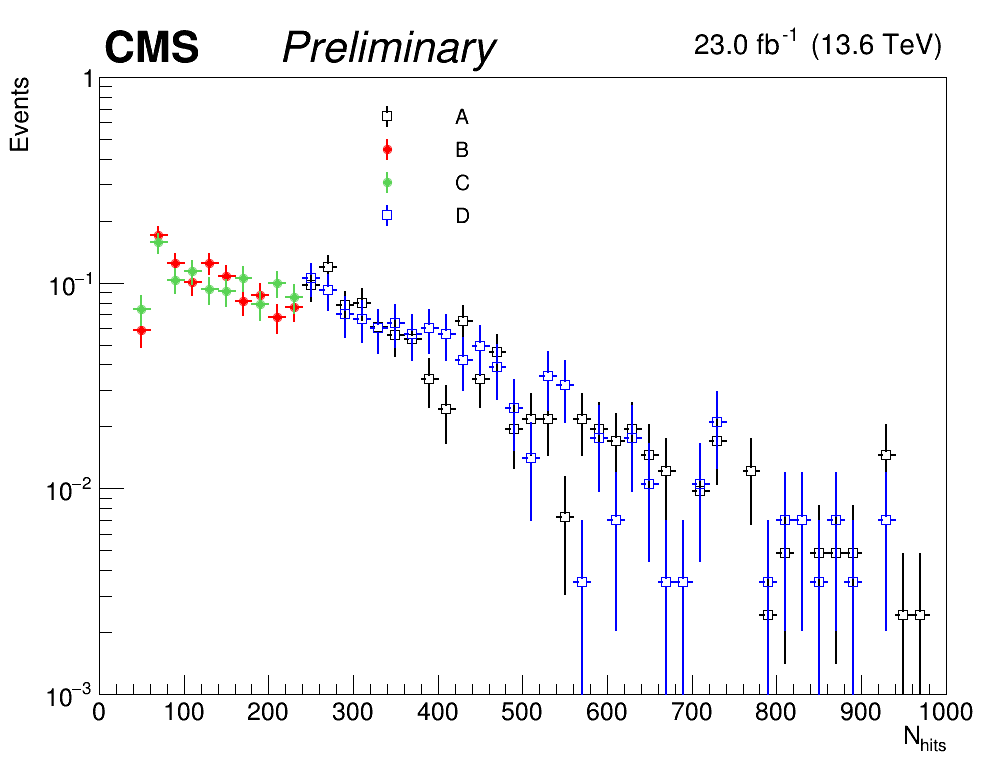

In [68]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.2,0.7,0.37+0.5,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
h3 = {}
can.cd()
scale=False
scale=True

#leg.SetHeader("First CSC cluster in L1/HLT plateau")
lab = ""

if category==1:
    for k in ['signal']:
        var = cscClusterSize[k][:,1]
        dphi = np.abs(dPhi_csc_csc[k])
        #tmp_cut = sel_ev_post[k]  & (np.abs(tmp_deta)<1.9) & (np.abs(t_var)<15) & (np.abs(t_spread_var)<20) & (sel_jetveto_csc[k][:,1]==True) & (sel_muonveto_csc[k][:,1]==True)#& (t_var<-15) #& (t_var<-15) # #& (tmp_dR>r) #(tmp_deta>=1.9)  & ( t_var<-15  )
        ma,mb,mc,md = return_abcd_masks(
                        var,dphi,
                        N_MIN,N_CUT,N_MAX,
                        PHI_MIN,2.85,PHI_MAX,
                        tmp_cut
                        )
        
        bins = [50,1.8,3.2]
        tit = '|#Delta #varphi| (CSC,CSC)'
        plname="deltaPhi"
        cons = dphi
        
        bins = [50,0,1000]
        tit = 'N_{hits}'
        plname="n_hits"
        cons = var
        
        h0[k] = create_TH1D( cons[ma],title="",axis_title = [tit,'Events'], binning=bins)
        h0[k].SetLineColor(1)
        h0[k].SetLineWidth(2)
        h0[k].SetMarkerColor(1)
        h0[k].SetMarkerStyle(25)
        h0[k].SetMarkerSize(1.2)
        if scale and h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())

        h1[k] = create_TH1D( cons[mb],title="",axis_title = [tit,'Events'], binning=bins)
        h1[k].SetLineColor(2)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(2)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
            
        h2[k] = create_TH1D(cons[mc],title="",axis_title = [tit,'Events'], binning=bins)
        h2[k].SetLineColor(8)
        h2[k].SetLineWidth(2)
        h2[k].SetMarkerColor(8)
        h2[k].SetMarkerStyle(20)
        h2[k].SetMarkerSize(1.2)
        if scale and h2[k].Integral()>0:h2[k].Scale(1./h2[k].Integral()) 
        
        h3[k] = create_TH1D(cons[md],title="",axis_title = [tit,'Events'], binning=bins)
        h3[k].SetLineColor(4)
        h3[k].SetLineWidth(2)
        h3[k].SetMarkerColor(4)
        h3[k].SetMarkerStyle(25)
        h3[k].SetMarkerSize(1.2)
        if scale and h3[k].Integral()>0:h3[k].Scale(1./h3[k].Integral())
            
        if not scale:
            h0[k].SetMinimum(0.1)
            h0[k].SetMaximum(1.e5)
        else:
            h0[k].SetMaximum(1)
            h0[k].SetMinimum(0.001)
        h0[k].Draw('PE same')
        h1[k].Draw('PE same')
        h2[k].Draw('PE same')
        h3[k].Draw('PE same')
        leg.AddEntry(h0[k],"A","PE")
        leg.AddEntry(h1[k],"B","PE")
        leg.AddEntry(h2[k],"C","PE")
        leg.AddEntry(h3[k],"D","PE")


#print("??")
leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
#can.Print("plots/V1p19_"+vers+"/ABCD_"+plname+"_signal_distribution_small_deta"+plot_string_plus+".pdf")
#can.Print("plots/V1p19_"+vers+"/ABCD_"+plname+"_signal_distribution_small_deta"+plot_string_plus+".png") 

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

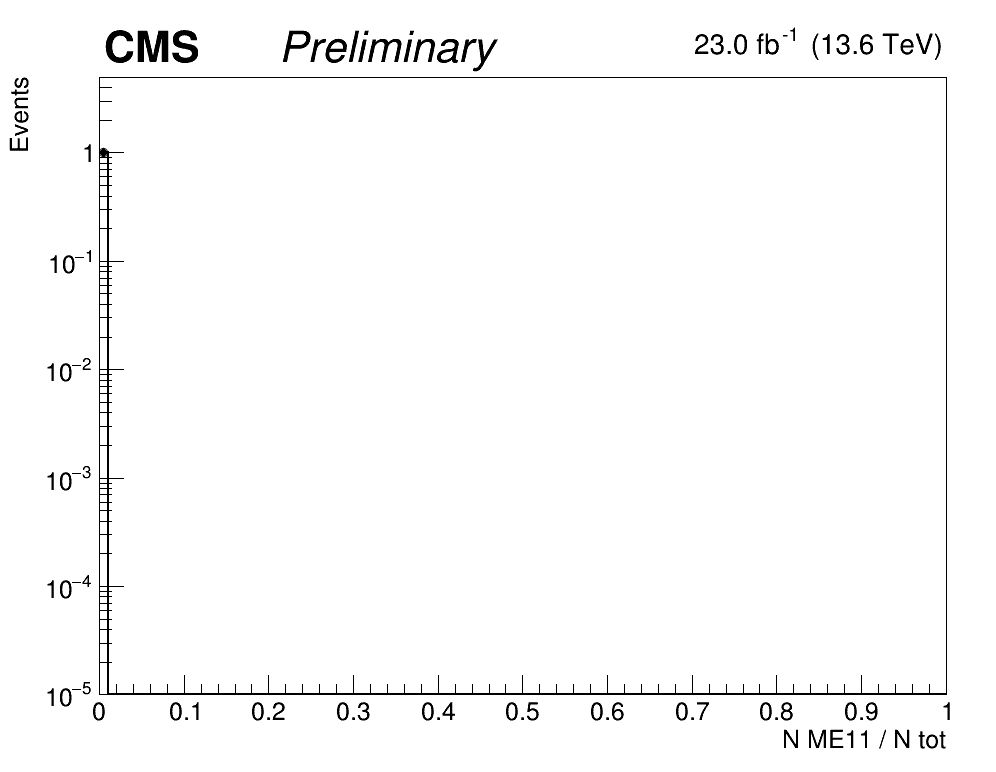

In [69]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.2,0.7,0.37+0.5,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
h3 = {}
can.cd()
scale=False
scale=True

#leg.SetHeader("First CSC cluster in L1/HLT plateau")
lab = ""

if category==1:
    for k in ['signal','data']:
        bins = [100,0,1]
        tit = "N ME11 / N tot"
        var = (cscClusterNRechitPlus11[k][:,1] + cscClusterNRechitMinus11[k][:,1])/cscClusterSize[k][:,1]
        dphi = np.abs(dPhi_csc_csc[k])
        tmp_cut = sel_ev_post[k]#  & (np.abs(tmp_deta)<1.9) & (np.abs(t_var)<15) & (np.abs(t_spread_var)<20) & (sel_jetveto_csc[k][:,1]==True) & (sel_muonveto_csc[k][:,1]==True)#& (t_var<-15) #& (t_var<-15) # #& (tmp_dR>r) #(tmp_deta>=1.9)  & ( t_var<-15  )

        if 'data' in k:
            tmp_cut = sel_ev_post[k] & (dphi<2.2)
        
        h0[k] = create_TH1D( var[tmp_cut],title="",axis_title = [tit,'Events'], binning=bins)
        h0[k].SetLineColor(1)
        h0[k].SetLineWidth(2)
        h0[k].SetMarkerColor(1)
        h0[k].SetMarkerStyle(20)
        h0[k].SetMarkerSize(1.2)
        if scale and h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())

            
        if not scale:
            h0[k].SetMinimum(0.1)
            h0[k].SetMaximum(1.e6)
        else:
            h0[k].SetMaximum(5)
            h0[k].SetMinimum(0.00001)
        if 'data' in k:
            h0[k].Draw('PE same')
        else:
            h0[k].Draw('HISTO same')
        #h1[k].Draw('PE same')
        #h2[k].Draw('PE same')
        #h3[k].Draw('PE same')
        #leg.AddEntry(h0[k],"A","PE")
        #leg.AddEntry(h1[k],"B","PE")
        #leg.AddEntry(h2[k],"C","PE")
        #leg.AddEntry(h3[k],"D","PE")


#print("??")
leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
#can.Print("plots/V1p19_"+vers+"/ABCD_"+plname+"_signal_distribution_small_deta"+plot_string_plus+".pdf")
#can.Print("plots/V1p19_"+vers+"/ABCD_"+plname+"_signal_distribution_small_deta"+plot_string_plus+".png") 

In [70]:
outDataCardsDir="/afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6/"
modelName="ggH_HToSSTobbbb_MH-125_MS-15_CTau1000"
m=15
ct=1000
bkg_unc = [1.]
bkg_unc_name = ["syst"]
sig_unc = {}
sig_unc_name = []
signal_region = 'a'
prefix = 'csccsc_'

for phi_cut_scan in phi_cut_scan_list:
    outdir = outDataCardsDir+'phi_cut_scan/'
    if phi_cut_scan<=PHI_MIN:
        continue
    if not os.path.isdir(outdir): os.mkdir(outdir)
    make_datacard_2tag(
        outdir,
        modelName+"_"+str(phi_cut_scan).replace(".","p"),  
        signal_rate[phi_cut_scan], 
        normalization, 
        bkg_rate[phi_cut_scan], 
        observation[phi_cut_scan], 
        bkg_unc, 
        bkg_unc_name, 
        sig_unc, 
        sig_unc_name,
        signal_region, 
        prefix
    )

In [71]:
for phi_cut_scan in phi_cut_scan_list:
    if phi_cut_scan<=PHI_MIN:continue
    print("\n")
    print("+++  ")
    print("+++  ", phi_cut_scan )
    print("+++  ")
    outdir = outDataCardsDir+'/phi_cut_scan/'
    text_file = open(outdir+modelName+"_"+str(phi_cut_scan).replace(".","p")+".txt", "r")
    for line in text_file:
        print(line.strip())
    text_file.close()
    print("\n")



+++  
+++   1.825
+++  
# signal norm 1
imax 4
jmax 1
kmax *
shapes * * FAKE
---------------
---------------
bin 	 chA 	 chB 	 chC 	 chD
observation 	 138.95 	 880.00 	  19.00 	   3.00
------------------------------
bin 	 chA 	 chA 	 chB 	 chB 	 chC 	 chC 	 chD 	 chD
process 	 ggH	 bkg 	 ggH	 bkg 	 ggH	 bkg 	 ggH	 bkg
process 	 0	 1	 0	 1	 0	 1	 0	 1
rate	 4.282997e+02 	 1 	 6.385230e+02 	 1 	 1.812270e+00 	 1 	 2.416360e+00 	 1
------------------------------
csccsc_A   rateParam       chA     bkg      (@0*@2/@1)                    csccsc_B,csccsc_C,csccsc_D
csccsc_B   rateParam       chB     bkg     880.00        [0,6160.00]
csccsc_C   rateParam       chC     bkg     19.00        [0,133.00]
csccsc_D   rateParam       chD     bkg     3.00        [0,21.00]
syst 	 lnN 	 - 	 - 	 - 	 - 	 - 	 - 	 - 	 2.0




+++  
+++   1.85
+++  
# signal norm 1
imax 4
jmax 1
kmax *
shapes * * FAKE
---------------
---------------
bin 	 chA 	 chB 	 chC 	 chD
observation 	  86.90 	 869.00 	  30.00 	   3.00

## Submit combine with condor

In [72]:
combine_dir = "/afs/desy.de/user/l/lbenato/cms-lpc-llp_combine/CMSSW_11_3_4/src/HiggsAnalysis/CombinedLimit/"
condor_dir = combine_dir + "condor_V1p19_v6/"
TOYS=False
blind = True
NCPUS   = 1
MEMORY  = 512
RUNTIME = 3600

if not os.path.isdir(condor_dir): os.mkdir(condor_dir)
else:
    print("Warning, directory exists, deleting old condor outputs ... ")
    os.system("ls " + condor_dir)
    os.system("rm " + condor_dir + "/*sh")
    os.system("rm " + condor_dir + "/*submit")
    os.system("rm " + condor_dir + "/*txt")

print("\n")
print("Condor stuff being stored in ", condor_dir)
print("\n")
original_location = os.popen("pwd").read()    

for phi_cut_scan in phi_cut_scan_list:
    if phi_cut_scan<=PHI_MIN:continue
    outdir = outDataCardsDir+'/phi_cut_scan/'
    results = outDataCardsDir+'/phi_cut_scan/'+'combine_results/'
    if not os.path.isdir(results): os.mkdir(results)
    card_name = modelName+"_"+str(phi_cut_scan).replace(".","p")#+".txt"
    #print(card_name)
    #os.system('cat '+card_name)
    #print("\n")
    
    if TOYS:
        print("Toys - to be implemented")
    else:
        os.chdir(condor_dir)
        os.system("pwd")
        print("----->")
        print("Doing Asymptotic!!!!!!!!!")
        with open('job_m'+str(m)+'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+'.sh', 'w') as fout:
            fout.write("#!/bin/sh\n")
            fout.write("source /etc/profile.d/modules.sh\n")
            fout.write("module use -a /afs/desy.de/group/cms/modulefiles/\n")
            fout.write("module load cmssw\n")
            fout.write('cd '+combine_dir+' \n')
            fout.write("cmsenv\n")
            fout.write("echo Running on: " + outdir+card_name+".txt from directory: \n")
            fout.write("pwd \n")
            if blind:
                fout.write("combine -M AsymptoticLimits --datacard " + outdir+card_name+".txt " + "  --run blind -m " + str(m) + " -n "+str(phi_cut_scan).replace(".","p")+" \n")
                #--SetParameters norm=1 --freezeParameters norm
            else:
                fout.write("combine -M AsymptoticLimits --datacard " + outdir+card_name+".txt " + " -m " + str(m) + " -n " +str(phi_cut_scan).replace(".","p")+ " \n")
        os.system('chmod 755 job_m'+str(m)+'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+'.sh')

        with open('submit_m'+str(m)+'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+'.submit', 'w') as fout:
            fout.write('executable   = ' + condor_dir + '/job_m'+ str(m) +'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+ '.sh \n')
            fout.write('output       = ' + condor_dir + '/out_m'+ str(m) +'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+ '.txt \n')
            fout.write('error        = ' + condor_dir + '/error_m'+ str(m) +'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+ '.txt \n')
            fout.write('log          = ' + condor_dir + '/log_m'+ str(m) +'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+ '.txt \n')
            fout.write(' \n')
            fout.write('Requirements = OpSysAndVer == "CentOS7" \n')
            fout.write(' \n')
            fout.write('Request_Cpus = ' + str(NCPUS) + ' \n')
            fout.write('Request_Memory = ' + str(MEMORY) + ' \n')
            #fout.write('+RequestRuntime = ' + str(RUNTIME) + ' \n')                                                                                        
            fout.write('batch_name = m'+str(m)+'ct'+str(ct)+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+'\n')
            fout.write('queue 1 \n')

        #submit condor                                                                                                                                      
        #os.system('condor_submit ' + 'submit_m'+str(m)+'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+'.submit' + ' \n')
        os.system("sh job_m"+str(m)+"_ctau"+str(ct)+"_phi"+str(phi_cut_scan).replace(".","p")+".sh > "+condor_dir + "/log_m"+ str(m) +"_ctau"+str(ct)+"_phi"+str(phi_cut_scan).replace(".","p")+".txt ")
        os.system("cat "+ condor_dir + "/log_m"+ str(m) +"_ctau"+str(ct)+"_phi"+str(phi_cut_scan).replace(".","p")+".txt | grep -e Observed -e Expected | awk '{print $NF}' > " + results + "/" + card_name +".txt \n")
        print("Results saved in "+results + card_name +".txt")
        os.chdir(original_location[:-1])
                
#os.system("eval `scramv1 runtime -sh`")

Warning, directory exists, deleting old condor outputs ... 


Condor stuff being stored in  /afs/desy.de/user/l/lbenato/cms-lpc-llp_combine/CMSSW_11_3_4/src/HiggsAnalysis/CombinedLimit/condor_V1p19_v6/


----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//phi_cut_scan/combine_results/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_1p825.txt
----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//phi_cut_scan/combine_results/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_1p85.txt
----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//phi_cut_scan/combine_results/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_1p875.txt
----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//ph

Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//phi_cut_scan/combine_results/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_2p75.txt
----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//phi_cut_scan/combine_results/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_2p7750000000000004.txt
----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//phi_cut_scan/combine_results/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_2p8.txt
----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//phi_cut_scan/combine_results/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_2p825.txt
----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//phi_cut_sc

In [73]:
#!cat /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//phi_cut_scan/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_2p2.txt

### Read and plot the limits

['0.2666', '0.3020', '0.3447', '0.3873', '0.4222']
['0.1684', '0.1934', '0.2275', '0.2575', '0.2855']
['0.1138', '0.1321', '0.1558', '0.1862', '0.2126']
['0.0802', '0.0945', '0.1128', '0.1366', '0.1616']
['0.0628', '0.0744', '0.0903', '0.1101', '0.1326']
['0.0494', '0.0593', '0.0728', '0.0899', '0.1109']
['0.0534', '0.0640', '0.0776', '0.0956', '0.1159']
['0.0455', '0.0545', '0.0669', '0.0834', '0.1026']
['0.0561', '0.0670', '0.0820', '0.1007', '0.1216']
['0.0504', '0.0605', '0.0742', '0.0917', '0.1121']
['0.0440', '0.0533', '0.0659', '0.0819', '0.1009']
['0.0447', '0.0541', '0.0669', '0.0832', '0.1024']
['0.0451', '0.0547', '0.0679', '0.0844', '0.1039']
['0.0434', '0.0525', '0.0649', '0.0815', '0.1010']
['0.0394', '0.0478', '0.0601', '0.0749', '0.0938']
['0.0362', '0.0442', '0.0552', '0.0706', '0.0884']
['0.0362', '0.0442', '0.0552', '0.0706', '0.0884']
['0.0345', '0.0424', '0.0532', '0.0681', '0.0857']
['0.0345', '0.0424', '0.0532', '0.0681', '0.0853']
['0.0345', '0.0424', '0.0532', 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file plots/V1p19_v6/ABCD_limits_scan_dphi_cut_exactly_2_csc_clusters_time_spread_cut_jet_muon_veto_2nd_IT_dR0p5.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v6/ABCD_limits_scan_dphi_cut_exactly_2_csc_clusters_time_spread_cut_jet_muon_veto_2nd_IT_dR0p5.png has been created


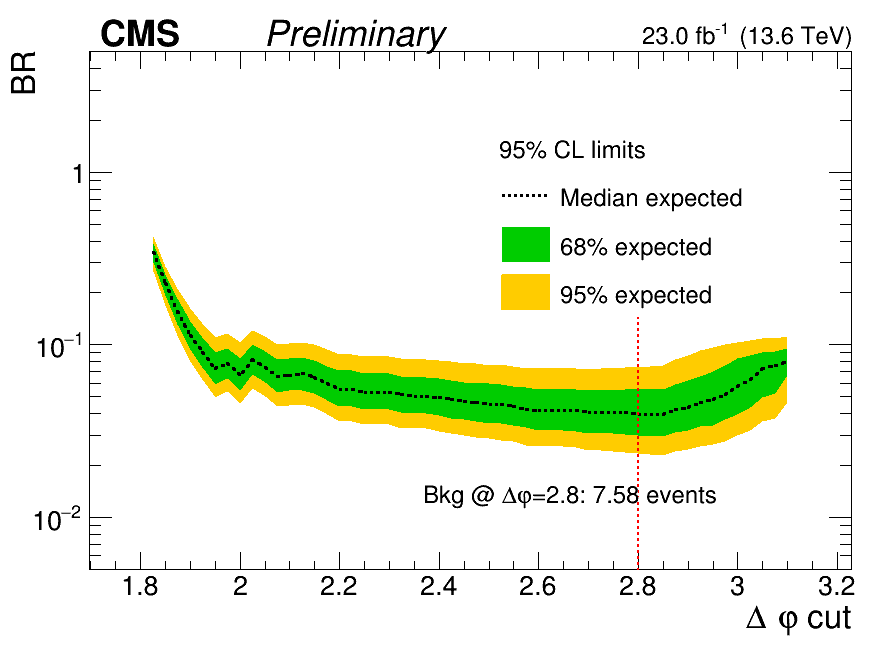

In [74]:
results = outDataCardsDir+'/phi_cut_scan/'+'combine_results/'
exp = []
xval = []
obs = {}
mean_val = {}
sigma_2_up = {}
sigma_1_up = {}
sigma_1_down = {}
sigma_2_down = {}
for phi_cut_scan in phi_cut_scan_list:
    if phi_cut_scan<=PHI_MIN:continue
    card_name = modelName+"_"+str(phi_cut_scan).replace(".","p")
    
    if not os.path.isfile(results+card_name+".txt"):
        continue
    card = open( results+card_name+".txt", 'r')
    val = card.read().splitlines()
    if len(val) == 0:
        continue
    if len(val) != 6 and not blind:
        continue
    print(val)
    
    if blind:
        sigma_2_down[phi_cut_scan] = float(val[0])
        sigma_1_down[phi_cut_scan] = float(val[1])
        mean_val[phi_cut_scan]     = float(val[2])
        exp.append(float(val[2]))
        sigma_1_up[phi_cut_scan]   = float(val[3])
        sigma_2_up[phi_cut_scan]   = float(val[4])
    else:
        obs[phi_cut_scan]          = float(val[0])
        sigma_2_down[phi_cut_scan] = float(val[1])
        sigma_1_down[phi_cut_scan] = float(val[2])
        mean_val[phi_cut_scan]     = float(val[3])
        exp.append(float(val[3]))
        sigma_1_up[phi_cut_scan]   = float(val[4])
        sigma_2_up[phi_cut_scan]   = float(val[5])
        
Obs0s = rt.TGraph()
Exp0s = rt.TGraph()
Exp1s = rt.TGraphAsymmErrors()
Exp2s = rt.TGraphAsymmErrors()

n=0
for phi_cut_scan in phi_cut_scan_list:                                                                                                    
    if phi_cut_scan not in mean_val.keys():
        continue
    if not blind:
        Obs0s.SetPoint(n, phi_cut_scan, obs[phi_cut_scan])
    #if phi_cut_scan==2. or phi_cut_scan==2.1:
    #    continue
    Exp0s.SetPoint(n, phi_cut_scan, mean_val[phi_cut_scan])
    Exp1s.SetPoint(n, phi_cut_scan, mean_val[phi_cut_scan])
    Exp1s.SetPointError(n, 0., 0., mean_val[phi_cut_scan]-sigma_1_down[phi_cut_scan], sigma_1_up[phi_cut_scan]-mean_val[phi_cut_scan])
    Exp2s.SetPoint(n, phi_cut_scan, mean_val[phi_cut_scan])
    Exp2s.SetPointError(n, 0., 0., mean_val[phi_cut_scan]-sigma_2_down[phi_cut_scan], sigma_2_up[phi_cut_scan]-mean_val[phi_cut_scan])
    n+=1
    
Exp2s.SetLineWidth(2)
Exp2s.SetLineStyle(1)
Exp0s.SetLineStyle(2)
Exp0s.SetLineWidth(3)                                                                                                                            
Obs0s.SetLineStyle(1)
Obs0s.SetLineWidth(3)                                                                                                                          
Exp1s.SetFillColor(417)
Exp1s.SetLineColor(417)
Exp2s.SetFillColor(800)
Exp2s.SetLineColor(800)
Exp2s.GetXaxis().SetTitle("#Delta #varphi cut")
Exp2s.GetYaxis().SetTitle("BR")
Exp2s.GetXaxis().SetNoExponent(True)
Exp2s.GetXaxis().SetMoreLogLabels(True)
Exp2s.GetXaxis().SetTitleSize(0.048)
Exp2s.GetYaxis().SetTitleSize(0.048)                                                                                                                                           
Exp2s.GetXaxis().SetTitleOffset(0.9)
Exp2s.GetYaxis().SetTitleOffset(0.85)

leg = rt.TLegend(0.55, 0.525-0.015, 0.9-0.05, 0.825-0.015)
leg.SetBorderSize(0)
leg.SetHeader("95% CL limits")
leg.SetTextSize(0.04)
c1 = rt.TCanvas("c1", "Exclusion Limits", 900, 675)
c1.cd()
c1.GetPad(0).SetBottomMargin(0.12)
c1.GetPad(0).SetTopMargin(0.08)
c1.GetPad(0).SetRightMargin(0.05)
c1.GetPad(0).SetTicks(1, 1)
c1.GetPad(0).SetLogy()

leg.AddEntry(Exp0s,  "Median expected", "l")
leg.AddEntry(Exp1s, "68% expected", "f")
leg.AddEntry(Exp2s, "95% expected", "f")
if not blind:
    leg.AddEntry(Obs0s, "Observed", "l")
Exp2s.GetXaxis().SetTitleSize(0.055)
Exp2s.GetYaxis().SetTitleSize(0.055)
Exp2s.GetXaxis().SetLabelSize(0.045)                                                                                 
Exp2s.GetYaxis().SetLabelSize(0.045)

for mv in mean_val.keys():
    xval.append(mv)
    exp.append(mean_val[mv])

best_phi = rt.TLine(xval[ np.argmin(exp) ],0.005,xval[ np.argmin(exp) ],1)
best_phi.SetLineColor(2)
best_phi.SetLineStyle(2)
best_phi.SetLineWidth(2)


Exp2s.SetMinimum(0.005)
Exp2s.SetMaximum(5)
Exp2s.Draw("A3")
Exp1s.Draw("SAME, 3")
Exp0s.Draw("SAME, L")
if not blind:
    Obs0s.Draw("SAME, L")
best_phi.Draw("SAME, L")
leg.Draw()

latex = rt.TLatex()
latex.SetNDC()
latex.SetTextAlign(33)
latex.SetTextSize(0.04)
latex.SetTextFont(42)
latex.DrawLatex(0.8,0.25, ("Bkg @ #Delta#varphi=%s: %.2f events" % ( str(xval[ np.argmin(exp) ]),bkg_rate[ xval[ np.argmin(exp) ] ] [0])))

c1.Draw()
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.97,top_marg_lumi=0.965)

c1.Print("plots/V1p19_"+vers+"/ABCD_limits_scan_dphi_cut"+plot_string_plus+".pdf")
c1.Print("plots/V1p19_"+vers+"/ABCD_limits_scan_dphi_cut"+plot_string_plus+".png")
#Store graphs for future comparisons
newFile = rt.TFile("plots/V1p19_"+vers+"/ABCD_limits_scan_dphi_cut"+plot_string_plus+".root", "RECREATE")
newFile.cd()
Exp0s.Write("exp")
Exp1s.Write("1sigma")
Exp2s.Write("2sigma")
c1.Write()
newFile.Close()
print("Info: written "+"plots/V1p19_"+vers+"/ABCD_limits_scan_dphi_cut"+plot_string_plus+".root")

In [75]:
print(np.argmin(exp))
print(exp)
print(exp[ np.argmin(exp) ])
print(xval[ np.argmin(exp) ])
print(xval)

39
[0.3447, 0.2275, 0.1558, 0.1128, 0.0903, 0.0728, 0.0776, 0.0669, 0.082, 0.0742, 0.0659, 0.0669, 0.0679, 0.0649, 0.0601, 0.0552, 0.0552, 0.0532, 0.0532, 0.0532, 0.0513, 0.0503, 0.0503, 0.0493, 0.0483, 0.0469, 0.0464, 0.0454, 0.0454, 0.0439, 0.0425, 0.0415, 0.0415, 0.0415, 0.0415, 0.0405, 0.0405, 0.0405, 0.0405, 0.0396, 0.0396, 0.0396, 0.0425, 0.0435, 0.0464, 0.0483, 0.0513, 0.0571, 0.063, 0.0728, 0.0757, 0.0806, 0.3447, 0.2275, 0.1558, 0.1128, 0.0903, 0.0728, 0.0776, 0.0669, 0.082, 0.0742, 0.0659, 0.0669, 0.0679, 0.0649, 0.0601, 0.0552, 0.0552, 0.0532, 0.0532, 0.0532, 0.0513, 0.0503, 0.0503, 0.0493, 0.0483, 0.0469, 0.0464, 0.0454, 0.0454, 0.0439, 0.0425, 0.0415, 0.0415, 0.0415, 0.0415, 0.0405, 0.0405, 0.0405, 0.0405, 0.0396, 0.0396, 0.0396, 0.0425, 0.0435, 0.0464, 0.0483, 0.0513, 0.0571, 0.063, 0.0728, 0.0757, 0.0806]
0.0396
2.8
[1.825, 1.85, 1.875, 1.9, 1.925, 1.95, 1.975, 2.0, 2.025, 2.05, 2.075, 2.1, 2.125, 2.15, 2.175, 2.2, 2.225, 2.25, 2.275, 2.3, 2.325, 2.35, 2.375, 2.4, 2.425,

### Comparing limits

No jet veto, no muon veto, no time spread cut

In [23]:
xval = [1.85, 1.9, 1.95, 2.0, 2.05, 2.1, 2.15, 2.2, 2.25, 2.3, 2.35, 2.4, 2.45, 2.5, 2.55, 2.6, 2.65, 2.7, 2.75, 2.8, 2.85, 2.90, 2.95, 3.0, 3.05, 3.1]
exp_1 = [0.2295, 0.1733, 0.1372, 0.1465, 0.1323, 0.1196, 0.1216, 0.1079, 0.104, 0.1021, 0.0972, 0.0938, 0.0884, 0.084, 0.0815, 0.0786, 0.0767, 0.0718, 0.0708, 0.0688, 0.0659, 0.0708, 0.0737, 0.0825, 0.0986, 0.1357, 0.2295, 0.1733, 0.1372, 0.1465, 0.1323, 0.1196, 0.1216, 0.1079, 0.104, 0.1021, 0.0972, 0.0938, 0.0884, 0.084, 0.0815, 0.0786, 0.0767, 0.0718, 0.0708, 0.0688, 0.0659, 0.0708, 0.0737, 0.0825, 0.0986, 0.1357]

No jet veto, no muon veto, yes time spread cut on 2nd cluster

In [24]:
exp_2 = [0.2119, 0.1602, 0.1147, 0.106, 0.0991, 0.0894, 0.0894, 0.0737, 0.0708, 0.0713, 0.0669, 0.0649, 0.061, 0.0591, 0.0571, 0.0532, 0.0532, 0.0513, 0.0513, 0.0503, 0.0503, 0.0547, 0.0576, 0.0674, 0.0825, 0.1045, 0.2119, 0.1602, 0.1147, 0.106, 0.0991, 0.0894, 0.0894, 0.0737, 0.0708, 0.0713, 0.0669, 0.0649, 0.061, 0.0591, 0.0571, 0.0532, 0.0532, 0.0513, 0.0513, 0.0503, 0.0503, 0.0547, 0.0576, 0.0674, 0.0825, 0.1045]

Yes jet veto, no muon veto, yes time spread cut on 2nd cluster

In [25]:
exp_3 = [0.2197, 0.1626, 0.1157, 0.106, 0.0981, 0.0894, 0.0894, 0.0737, 0.0708, 0.0708, 0.0669, 0.064, 0.061, 0.0591, 0.0562, 0.0522, 0.0522, 0.0503, 0.0503, 0.0498, 0.0493, 0.0542, 0.0571, 0.0669, 0.0811, 0.105, 0.2197, 0.1626, 0.1157, 0.106, 0.0981, 0.0894, 0.0894, 0.0737, 0.0708, 0.0708, 0.0669, 0.064, 0.061, 0.0591, 0.0562, 0.0522, 0.0522, 0.0503, 0.0503, 0.0498, 0.0493, 0.0542, 0.0571, 0.0669, 0.0811, 0.105]

Yes jet veto, yes muon veto, yes time spread cut on 2nd cluster

In [26]:
exp_4 = [0.2197, 0.1626, 0.1157, 0.106, 0.0981, 0.0894, 0.0894, 0.0737, 0.0708, 0.0708, 0.0669, 0.064, 0.061, 0.0591, 0.0562, 0.0522, 0.0522, 0.0503, 0.0503, 0.0498, 0.0493, 0.0542, 0.0571, 0.0669, 0.0811, 0.105, 0.2197, 0.1626, 0.1157, 0.106, 0.0981, 0.0894, 0.0894, 0.0737, 0.0708, 0.0708, 0.0669, 0.064, 0.061, 0.0591, 0.0562, 0.0522, 0.0522, 0.0503, 0.0503, 0.0498, 0.0493, 0.0542, 0.0571, 0.0669, 0.0811, 0.105]

None
x[0]=1.85, y[0]=0.2295
x[1]=1.9, y[1]=0.1733
x[2]=1.95, y[2]=0.1372
x[3]=2, y[3]=0.1465
x[4]=2.05, y[4]=0.1323
x[5]=2.1, y[5]=0.1196
x[6]=2.15, y[6]=0.1216
x[7]=2.2, y[7]=0.1079
x[8]=2.25, y[8]=0.104
x[9]=2.3, y[9]=0.1021
x[10]=2.35, y[10]=0.0972
x[11]=2.4, y[11]=0.0938
x[12]=2.45, y[12]=0.0884
x[13]=2.5, y[13]=0.084
x[14]=2.55, y[14]=0.0815
x[15]=2.6, y[15]=0.0786
x[16]=2.65, y[16]=0.0767
x[17]=2.7, y[17]=0.0718
x[18]=2.75, y[18]=0.0708
x[19]=2.8, y[19]=0.0688
x[20]=2.85, y[20]=0.0659
x[21]=2.9, y[21]=0.0708
x[22]=2.95, y[22]=0.0737
x[23]=3, y[23]=0.0825
x[24]=3.05, y[24]=0.0986
x[25]=3.1, y[25]=0.1357


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file plots/V1p19_v6/ABCD_limits_compare_vetoes_scan_dphi_cut_exactly_2_csc_clusters_ME_veto_time_spread_cut_jet_muon_veto_2nd_IT_dR0p5.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v6/ABCD_limits_compare_vetoes_scan_dphi_cut_exactly_2_csc_clusters_ME_veto_time_spread_cut_jet_muon_veto_2nd_IT_dR0p5.png has been created


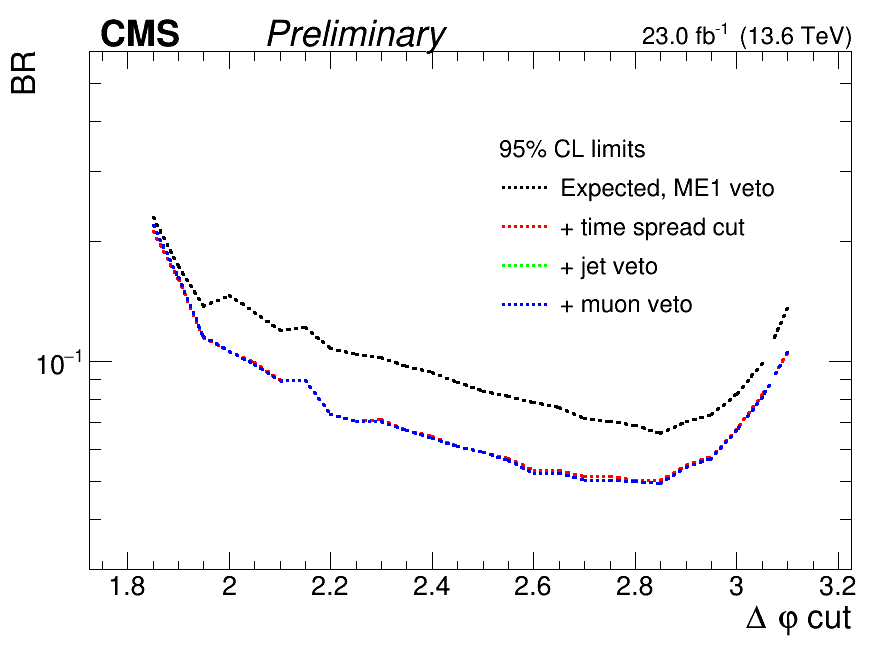

In [27]:
Exp0s_1 = rt.TGraph(len(xval),np.array(xval),np.array(exp_1))
Exp0s_2 = rt.TGraph(len(xval),np.array(xval),np.array(exp_2))
Exp0s_3 = rt.TGraph(len(xval),np.array(xval),np.array(exp_3))
Exp0s_4 = rt.TGraph(len(xval),np.array(xval),np.array(exp_4))
Exp0s_1.SetTitle("")

Exp0s_1.SetLineWidth(3)
Exp0s_1.SetLineStyle(2)
Exp0s_1.SetLineColor(1)

Exp0s_2.SetLineWidth(3)
Exp0s_2.SetLineStyle(2)
Exp0s_2.SetLineColor(2)

Exp0s_3.SetLineWidth(3)
Exp0s_3.SetLineStyle(2)
Exp0s_3.SetLineColor(3)

Exp0s_4.SetLineWidth(3)
Exp0s_4.SetLineStyle(2)
Exp0s_4.SetLineColor(4)

Exp0s_1.GetXaxis().SetTitle("#Delta #varphi cut")
Exp0s_1.GetYaxis().SetTitle("BR")
Exp0s_1.GetXaxis().SetNoExponent(True)
Exp0s_1.GetXaxis().SetMoreLogLabels(True)
Exp0s_1.GetXaxis().SetTitleSize(0.055)
Exp0s_1.GetYaxis().SetTitleSize(0.055)             
Exp0s_1.GetXaxis().SetTitleOffset(0.9)
Exp0s_1.GetYaxis().SetTitleOffset(0.85)
Exp0s_1.GetXaxis().SetLabelSize(0.045)                                                                                 
Exp0s_1.GetYaxis().SetLabelSize(0.045)

print(Exp0s_1.Print())

leg = rt.TLegend(0.55, 0.525-0.025, 0.9-0.05, 0.825-0.025)
leg.SetBorderSize(0)
leg.SetHeader("95% CL limits")
leg.SetTextSize(0.04)

c1 = rt.TCanvas("c1", "Exclusion Limits", 900, 675)
c1.cd()
c1.GetPad(0).SetBottomMargin(0.12)
c1.GetPad(0).SetTopMargin(0.08)
c1.GetPad(0).SetRightMargin(0.05)
c1.GetPad(0).SetTicks(1, 1)
c1.GetPad(0).SetLogy()

leg.AddEntry(Exp0s_1,  "Expected, ME1 veto", "l")
leg.AddEntry(Exp0s_2,  "+ time spread cut", "l")
leg.AddEntry(Exp0s_3,  "+ jet veto", "l")
leg.AddEntry(Exp0s_4,  "+ muon veto", "l")


Exp0s_1.SetMinimum(0.03)
Exp0s_1.SetMaximum(0.6)
Exp0s_1.Draw("AL")
Exp0s_2.Draw("L sames")
Exp0s_3.Draw("L sames")
Exp0s_4.Draw("L sames")
leg.Draw()
c1.Draw()
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.97,top_marg_lumi=0.965)

c1.Print("plots/V1p19_"+vers+"/ABCD_limits_compare_vetoes_scan_dphi_cut"+plot_string_plus+".pdf")
c1.Print("plots/V1p19_"+vers+"/ABCD_limits_compare_vetoes_scan_dphi_cut"+plot_string_plus+".png")

## N hits scan

In [76]:
PHI_CUT_SEL = 2.8#5
print(np.linspace(100,600,50+1).astype(int))

[100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270
 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450
 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600]


In [77]:
n_cut_scan_list = np.array([100,200,300,400])#np.linspace(1.5,3.1,32+1)
n_cut_scan_list = np.linspace(100,600,50+1).astype(int)

#LESS
#n_cut_scan_list = np.array([200,300,400,1000])

time_cut_string = "IT"
plot_string_plus = plot_string+"_"+time_cut_string+"_dR"+str( dr_min_list[0] ).replace(".","p")
leghead = "|#Delta#eta|<1.9, "+time_cut_string+", #DeltaR>"+str(dr_min_list[0])+","

#one per min dphi cut
bkg_rate = {}
#bkg_unc = {}
observation = {}
signal_rate = {}

normalization = 1

for n_cut_scan in n_cut_scan_list:
    signal_rate[n_cut_scan] = {}

#print('k\t n\t B\t C\t D\t A\t pred\t\t zval\t perc')
if category==1:
    #Signal
    #Data
    for k in ['data','signal']:
        tmp_dphi = np.abs( dPhi_csc_csc[k] )
        tmp_deta = np.abs(  dEta_csc_csc[k] )
        tmp_dR = np.abs(  dR_csc_csc[k] )
        tmp_dt = np.abs( dt_csc_csc[k] )
        var = cscClusterSize[k][:,1]
        t_var = cscClusterTime[k][:,1]
        t_spread_var = cscClusterTimeSpread[k][:,1]
        dphi = np.abs(dPhi_csc_csc[k])
        tmp_cut = sel_ev_post[k]  & (np.abs(tmp_deta)<1.9) & (np.abs(t_var)<15) & (np.abs(t_spread_var)<20) & (sel_jetveto_csc[k][:,1]==True) & (sel_muonveto_csc[k][:,1]==True)#& (t_var<-15) #& (t_var<-15) # #& (tmp_dR>r) #(tmp_deta>=1.9)  & ( t_var<-15  )
        for n_cut_scan in n_cut_scan_list:
            if n_cut_scan<=N_MIN: continue
            if 'data' in k:
                a[k],b[k],c[k],d[k],pred,unc_pred, p_value, z_value = run_abcd(
                    var,dphi,
                    N_MIN,n_cut_scan,N_MAX,
                    PHI_MIN,PHI_CUT_SEL,PHI_MAX,
                    tmp_cut,
                    do_b_extrapolation=True
                    )
                print('k\t n\t B\t C\t D\t A\t pred\t\t zval\t perc')
                print("%s\t %i\t %.2f\t %i\t %.2f\t %i\t %.2f +- %.2f\t %.2f\t %.2f" % (k,n_cut_scan,b[k],c[k],d[k],a[k],pred,unc_pred,z_value, 100*(pred-a[k])/a[k]))
                print("\n")
                observation[n_cut_scan] = [ pred,b[k],c[k],d[k] ]
                bkg_rate[n_cut_scan] = [ pred,b[k],c[k],d[k] ]
                #bkg_unc[phi_min_scan] = [ unc_pred,np.sqrt(b[k]),np.sqrt(c[k]),np.sqrt(d[k]) ]
            else:
                ma,mb,mc,md = return_abcd_masks(
                    var,dphi,
                    N_MIN,n_cut_scan,N_MAX,
                    PHI_MIN,PHI_CUT_SEL,PHI_MAX,
                    tmp_cut
                    )
                a[k] = (np.sum(weight[k][ ma ]))*lumi
                b[k] = (np.sum(weight[k][ mb ]))*lumi
                c[k] = (np.sum(weight[k][ mc ]))*lumi
                d[k] = (np.sum(weight[k][ md ]))*lumi
                print("%s\t %i\t %.2f\t %.2f\t %.2f\t %.2f\t "%(k,n_cut_scan,b[k],c[k],d[k],a[k]))
                signal_rate[n_cut_scan]['ggH'] = [ a[k]*normalization,b[k]*normalization,c[k]*normalization,d[k]*normalization ]



d	 d low	 d pred
137	 52	  130.00
k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 100	 208.00	 540	 130.00	 45	 50.07 +- 3.47	 0.70	 11.28


d	 d low	 d pred
115	 43	  107.50
k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 110	 219.00	 562	 107.50	 34	 41.89 +- 2.83	 1.21	 23.21


d	 d low	 d pred
95	 35	  87.50
k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 120	 221.00	 582	 87.50	 32	 33.23 +- 2.24	 0.25	 3.83


d	 d low	 d pred
80	 31	  77.50
k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 130	 223.00	 597	 77.50	 30	 28.95 +- 1.94	 -0.12	 -3.50


d	 d low	 d pred
73	 29	  72.50
k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 140	 225.00	 604	 72.50	 28	 27.01 +- 1.80	 -0.12	 -3.54


d	 d low	 d pred
68	 27	  67.50


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


b	 b pred
230	230.00
k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 150	 230.00	 609	 67.50	 23	 25.49 +- 1.68	 0.53	 10.84


d	 d low	 d pred
56	 23	  57.50
b	 b pred
231	237.49


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 160	 237.49	 621	 57.50	 22	 21.99 +- 1.43	 0.07	 -0.05


d	 d low	 d pred
51	 19	  47.50
b	 b pred
236	241.00


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 170	 241.00	 626	 47.50	 17	 18.29 +- 1.18	 0.37	 7.57


d	 d low	 d pred
49	 18	  45.00
b	 b pred
236	242.94


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 180	 242.94	 628	 45.00	 17	 17.41 +- 1.12	 0.17	 2.40


d	 d low	 d pred
45	 16	  40.00
b	 b pred
237	243.87


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 190	 243.87	 632	 40.00	 16	 15.43 +- 0.99	 -0.05	 -3.53


d	 d low	 d pred
43	 15	  37.50
b	 b pred
239	247.61


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 200	 247.61	 634	 37.50	 14	 14.65 +- 0.93	 0.25	 4.61


d	 d low	 d pred
33	 13	  32.50
b	 b pred
244	249.57


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 210	 249.57	 644	 32.50	 9	 12.59 +- 0.80	 1.15	 39.94


d	 d low	 d pred
31	 13	  32.50
b	 b pred
246	249.36


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 220	 249.36	 646	 32.50	 7	 12.55 +- 0.79	 1.79	 79.21


d	 d low	 d pred
27	 10	  25.00
b	 b pred
247	252.17


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 230	 252.17	 650	 25.00	 6	 9.70 +- 0.61	 1.39	 61.65


d	 d low	 d pred
25	 8	  20.00
b	 b pred
247	253.72


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 240	 253.72	 652	 20.00	 6	 7.78 +- 0.49	 0.79	 29.71


d	 d low	 d pred
24	 8	  20.00
b	 b pred
247	253.16


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 250	 253.16	 653	 20.00	 6	 7.75 +- 0.49	 0.77	 29.23


d	 d low	 d pred
24	 8	  20.00
b	 b pred
247	252.77


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 260	 252.77	 653	 20.00	 6	 7.74 +- 0.49	 0.77	 29.03


d	 d low	 d pred
24	 8	  20.00
b	 b pred
248	255.68


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 270	 255.68	 653	 20.00	 5	 7.83 +- 0.49	 1.21	 56.62


d	 d low	 d pred
23	 7	  17.50
b	 b pred
248	256.27


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 280	 256.27	 654	 17.50	 5	 6.86 +- 0.43	 0.88	 37.15


d	 d low	 d pred
22	 7	  17.50
b	 b pred
248	257.31


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 290	 257.31	 655	 17.50	 5	 6.87 +- 0.43	 0.89	 37.49


d	 d low	 d pred
22	 7	  17.50
b	 b pred
248	255.73


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 300	 255.73	 655	 17.50	 5	 6.83 +- 0.43	 0.87	 36.65


d	 d low	 d pred
19	 7	  17.50
b	 b pred
248	255.69


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 310	 255.69	 658	 17.50	 5	 6.80 +- 0.43	 0.86	 36.00


d	 d low	 d pred
16	 6	  15.00
b	 b pred
248	260.54


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 320	 260.54	 661	 15.00	 5	 5.91 +- 0.37	 0.53	 18.25


d	 d low	 d pred
15	 5	  12.50
b	 b pred
248	260.73


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 330	 260.73	 662	 12.50	 5	 4.92 +- 0.30	 0.11	 -1.54


d	 d low	 d pred
15	 5	  12.50
b	 b pred
250	258.48


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 340	 258.48	 662	 12.50	 3	 4.88 +- 0.30	 1.09	 62.69


d	 d low	 d pred
15	 5	  12.50
b	 b pred
250	258.99


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 350	 258.99	 662	 12.50	 3	 4.89 +- 0.30	 1.09	 63.01


d	 d low	 d pred
14	 5	  12.50
b	 b pred
250	263.12


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 360	 263.12	 663	 12.50	 3	 4.96 +- 0.31	 1.12	 65.36


d	 d low	 d pred
12	 4	  10.00
b	 b pred
250	266.52


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 370	 266.52	 665	 10.00	 3	 4.01 +- 0.25	 0.71	 33.59


d	 d low	 d pred
12	 4	  10.00
b	 b pred
250	271.46


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 380	 271.46	 665	 10.00	 3	 4.08 +- 0.25	 0.74	 36.07


d	 d low	 d pred
10	 4	  10.00
b	 b pred
250	288.81


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 390	 288.81	 667	 10.00	 3	 4.33 +- 0.25	 0.86	 44.33


d	 d low	 d pred
10	 4	  10.00
b	 b pred
250	271.69


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 400	 271.69	 667	 10.00	 3	 4.07 +- 0.25	 0.74	 35.78


d	 d low	 d pred
9	 4	  10.00
b	 b pred
250	273.83


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 410	 273.83	 668	 10.00	 3	 4.10 +- 0.25	 0.75	 36.64


d	 d low	 d pred
8	 4	  10.00
b	 b pred
250	270.06


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 420	 270.06	 669	 10.00	 3	 4.04 +- 0.25	 0.72	 34.56


d	 d low	 d pred
7	 3	  7.50
b	 b pred
250	270.08


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 430	 270.08	 670	 7.50	 3	 3.02 +- 0.18	 0.20	 0.78


d	 d low	 d pred
6	 2	  5.00
b	 b pred
250	273.33


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 440	 273.33	 671	 5.00	 3	 2.04 +- 0.12	 -0.43	 -32.11


d	 d low	 d pred
6	 2	  5.00
b	 b pred
250	267.19


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 450	 267.19	 671	 5.00	 3	 1.99 +- 0.12	 -0.47	 -33.63


d	 d low	 d pred
6	 2	  5.00
b	 b pred
250	272.35


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 460	 272.35	 671	 5.00	 3	 2.03 +- 0.12	 -0.44	 -32.35


d	 d low	 d pred
5	 2	  5.00
b	 b pred
250	271.87


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 470	 271.87	 672	 5.00	 3	 2.02 +- 0.12	 -0.44	 -32.57


d	 d low	 d pred
5	 2	  5.00
b	 b pred
250	278.66


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 480	 278.66	 672	 5.00	 3	 2.07 +- 0.12	 -0.40	 -30.89


d	 d low	 d pred
5	 2	  5.00
b	 b pred
250	280.91


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 490	 280.91	 672	 5.00	 3	 2.09 +- 0.12	 -0.39	 -30.33


d	 d low	 d pred
5	 2	  5.00
b	 b pred
250	286.71


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 500	 286.71	 672	 5.00	 3	 2.13 +- 0.13	 -0.36	 -28.89


d	 d low	 d pred
5	 2	  5.00
b	 b pred
250	282.39


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 510	 282.39	 672	 5.00	 3	 2.10 +- 0.13	 -0.38	 -29.96


d	 d low	 d pred
4	 2	  5.00
b	 b pred
250	294.25


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 520	 294.25	 673	 5.00	 3	 2.19 +- 0.13	 -0.32	 -27.13


d	 d low	 d pred
4	 2	  5.00
b	 b pred
250	296.06


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 530	 296.06	 673	 5.00	 3	 2.20 +- 0.13	 -0.31	 -26.68


d	 d low	 d pred
4	 2	  5.00
b	 b pred
250	287.32


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 540	 287.32	 673	 5.00	 3	 2.13 +- 0.13	 -0.36	 -28.85


d	 d low	 d pred
4	 2	  5.00
b	 b pred
250	282.46


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 550	 282.46	 673	 5.00	 3	 2.10 +- 0.12	 -0.39	 -30.05


d	 d low	 d pred
4	 2	  5.00
b	 b pred
250	281.12


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 560	 281.12	 673	 5.00	 3	 2.09 +- 0.12	 -0.39	 -30.38


d	 d low	 d pred
4	 2	  5.00
b	 b pred
250	283.46


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 570	 283.46	 673	 5.00	 3	 2.11 +- 0.13	 -0.38	 -29.80


d	 d low	 d pred
3	 2	  5.00
b	 b pred
251	293.07


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 580	 293.07	 674	 5.00	 2	 2.17 +- 0.13	 0.35	 8.70


d	 d low	 d pred
3	 2	  5.00
b	 b pred
251	295.47


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 590	 295.47	 674	 5.00	 2	 2.19 +- 0.13	 0.37	 9.60


d	 d low	 d pred
3	 2	  5.00
b	 b pred
251	304.53


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 600	 304.53	 674	 5.00	 2	 2.26 +- 0.13	 0.41	 12.96


signal	 100	 139.54	 81.55	 316.54	 533.41	 
signal	 110	 159.48	 92.43	 305.67	 513.48	 
signal	 120	 180.62	 108.74	 289.36	 492.33	 
signal	 130	 201.16	 122.03	 276.07	 471.79	 
signal	 140	 228.35	 131.69	 266.40	 444.61	 
signal	 150	 243.45	 144.38	 253.72	 429.51	 
signal	 160	 269.42	 154.65	 243.45	 403.53	 
signal	 170	 285.73	 169.15	 228.95	 387.22	 
signal	 180	 303.25	 180.02	 218.08	 369.70	 
signal	 190	 318.96	 189.68	 208.41	 354.00	 
signal	 200	 336.48	 199.95	 198.14	 336.48	 
signal	 210	 347.96	 210.83	 187.27	 325.00	 
signal	 220	 366.68	 222.31	 175.79	 306.27	 
signal	 230	 383.60	 230.76	 167.33	 289.36	 
signal	 240	 398.10	 242.24	 155.86	 274.86	 
signal	 250	 415.01	 251.30	 146.79	 257.95	 
signal	 260	 425.28	 257.34	 140.75	 247.68	 
signal	 270	 440.99	 262.78	 135.32	 231.97	 
signal	 280	 456.09	 271.84	 126.25	 216.87	 
signal	 290	 465.75	 277.28	 12

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


In [78]:
outDataCardsDir="/afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6/"
modelName="ggH_HToSSTobbbb_MH-125_MS-15_CTau1000"
m=15
ct=1000
bkg_unc = [1.]
bkg_unc_name = ["syst"]
sig_unc = {}
sig_unc_name = []
signal_region = 'a'
prefix = 'csccsc_'

for n_cut_scan in n_cut_scan_list:
    outdir = outDataCardsDir+'n_cut_scan/'
    if n_cut_scan<=N_MIN:
        continue
    if not os.path.isdir(outdir): os.mkdir(outdir)
    make_datacard_2tag(
        outdir,
        modelName+"_"+str(int(n_cut_scan)),  
        signal_rate[n_cut_scan], 
        normalization, 
        bkg_rate[n_cut_scan], 
        observation[n_cut_scan], 
        bkg_unc, 
        bkg_unc_name, 
        sig_unc, 
        sig_unc_name,
        signal_region, 
        prefix
    )

In [79]:
for n_cut_scan in n_cut_scan_list:
    if n_cut_scan<=N_MIN:continue
    print("\n")
    print("+++  ")
    print("+++  ", n_cut_scan )
    print("+++  ")
    outdir = outDataCardsDir+'/n_cut_scan/'
    text_file = open(outdir+modelName+"_"+str(int(n_cut_scan))+".txt", "r")
    for line in text_file:
        print(line.strip())
    text_file.close()
    print("\n")



+++  
+++   100
+++  
# signal norm 1
imax 4
jmax 1
kmax *
shapes * * FAKE
---------------
---------------
bin 	 chA 	 chB 	 chC 	 chD
observation 	  50.07 	 208.00 	 540.00 	 130.00
------------------------------
bin 	 chA 	 chA 	 chB 	 chB 	 chC 	 chC 	 chD 	 chD
process 	 ggH	 bkg 	 ggH	 bkg 	 ggH	 bkg 	 ggH	 bkg
process 	 0	 1	 0	 1	 0	 1	 0	 1
rate	 5.334114e+02 	 1 	 1.395448e+02 	 1 	 8.155215e+01 	 1 	 3.165431e+02 	 1
------------------------------
csccsc_A   rateParam       chA     bkg      (@0*@2/@1)                    csccsc_B,csccsc_C,csccsc_D
csccsc_B   rateParam       chB     bkg     208.00        [0,1456.00]
csccsc_C   rateParam       chC     bkg     540.00        [0,3780.00]
csccsc_D   rateParam       chD     bkg     130.00        [0,910.00]
syst 	 lnN 	 - 	 - 	 - 	 - 	 - 	 - 	 - 	 2.0




+++  
+++   110
+++  
# signal norm 1
imax 4
jmax 1
kmax *
shapes * * FAKE
---------------
---------------
bin 	 chA 	 chB 	 chC 	 chD
observation 	  41.89 	 219.00 	 562.00 	 107.

## Submit combine

In [80]:
combine_dir = "/afs/desy.de/user/l/lbenato/cms-lpc-llp_combine/CMSSW_11_3_4/src/HiggsAnalysis/CombinedLimit/"
condor_dir = combine_dir + "condor_V1p19_v6/"
TOYS=False
blind = True
NCPUS   = 1
MEMORY  = 512
RUNTIME = 3600

if not os.path.isdir(condor_dir): os.mkdir(condor_dir)
else:
    print("Warning, directory exists, deleting old condor outputs ... ")
    os.system("ls " + condor_dir)
    os.system("rm " + condor_dir + "/*sh")
    os.system("rm " + condor_dir + "/*submit")
    os.system("rm " + condor_dir + "/*txt")

print("\n")
print("Condor stuff being stored in ", condor_dir)
print("\n")
original_location = os.popen("pwd").read()    

for n_cut_scan in n_cut_scan_list:
    if n_cut_scan<=N_MIN:continue
    outdir = outDataCardsDir+'/n_cut_scan/'
    results = outDataCardsDir+'/n_cut_scan/'+'combine_results/'
    if not os.path.isdir(results): os.mkdir(results)
    card_name = modelName+"_"+str(int(n_cut_scan))
    
    label = '_m'+str(m)+'_ctau'+str(ct)+'_n'+str(int(n_cut_scan))
    
    if TOYS:
        print("Toys - to be implemented")
    else:
        os.chdir(condor_dir)
        os.system("pwd")
        print("----->")
        print("Doing Asymptotic!!!!!!!!!")
        with open('job_m'+str(m)+'_ctau'+str(ct)+'_n'+str(int(n_cut_scan))+'.sh', 'w') as fout:
            fout.write("#!/bin/sh\n")
            fout.write("source /etc/profile.d/modules.sh\n")
            fout.write("module use -a /afs/desy.de/group/cms/modulefiles/\n")
            fout.write("module load cmssw\n")
            fout.write('cd '+combine_dir+' \n')
            fout.write("cmsenv\n")
            fout.write("echo Running on: " + outdir+card_name+".txt from directory: \n")
            fout.write("pwd \n")
            if blind:
                fout.write("combine -M AsymptoticLimits --datacard " + outdir+card_name+".txt " + "  --run blind -m " + str(m) + " -n "+str(int(n_cut_scan))+" \n")
                #--SetParameters norm=1 --freezeParameters norm
            else:
                fout.write("combine -M AsymptoticLimits --datacard " + outdir+card_name+".txt " + " -m " + str(m) + " -n " +str(int(n_cut_scan))+ " \n")
        os.system('chmod 755 job_m'+str(m)+'_ctau'+str(ct)+'_n'+str(int(n_cut_scan))+'.sh')

        with open('submit_m'+str(m)+'_ctau'+str(ct)+'_n'+str(int(n_cut_scan))+'.submit', 'w') as fout:
            fout.write('executable   = ' + condor_dir + '/job_m'+ str(m) +'_ctau'+str(ct)+'_n'+str(int(n_cut_scan))+ '.sh \n')
            fout.write('output       = ' + condor_dir + '/out_m'+ str(m) +'_ctau'+str(ct)+'_n'+str(int(n_cut_scan))+ '.txt \n')
            fout.write('error        = ' + condor_dir + '/error_m'+ str(m) +'_ctau'+str(ct)+'_n'+str(int(n_cut_scan))+ '.txt \n')
            fout.write('log          = ' + condor_dir + '/log_m'+ str(m) +'_ctau'+str(ct)+'_n'+str(int(n_cut_scan))+ '.txt \n')
            fout.write(' \n')
            fout.write('Requirements = OpSysAndVer == "CentOS7" \n')
            fout.write(' \n')
            fout.write('Request_Cpus = ' + str(NCPUS) + ' \n')
            fout.write('Request_Memory = ' + str(MEMORY) + ' \n')
            #fout.write('+RequestRuntime = ' + str(RUNTIME) + ' \n')                                                                                        
            fout.write('batch_name = m'+str(m)+'ct'+str(ct)+str(ct)+'_n'+str(int(n_cut_scan))+'\n')
            fout.write('queue 1 \n')

        #submit condor                                                                                                                                      
        #os.system('condor_submit ' + 'submit_m'+str(m)+'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+'.submit' + ' \n')
        os.system("sh job_m"+str(m)+"_ctau"+str(ct)+"_n"+str(int(n_cut_scan))+".sh > "+condor_dir + "/log_m"+ str(m) +"_ctau"+str(ct)+"_n"+str(int(n_cut_scan))+".txt ")
        os.system("cat "+ condor_dir + "/log_m"+ str(m) +"_ctau"+str(ct)+"_n"+str(int(n_cut_scan))+".txt | grep -e Observed -e Expected | awk '{print $NF}' > " + results + "/" + card_name +".txt \n")
        print("Results saved in "+results + card_name +".txt")
        os.chdir(original_location[:-1])
                
#os.system("eval `scramv1 runtime -sh`")

Warning, directory exists, deleting old condor outputs ... 


Condor stuff being stored in  /afs/desy.de/user/l/lbenato/cms-lpc-llp_combine/CMSSW_11_3_4/src/HiggsAnalysis/CombinedLimit/condor_V1p19_v6/


----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//n_cut_scan/combine_results/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_100.txt
----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//n_cut_scan/combine_results/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_110.txt
----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//n_cut_scan/combine_results/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_120.txt
----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//n_cut_scan/co

Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//n_cut_scan/combine_results/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_480.txt
----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//n_cut_scan/combine_results/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_490.txt
----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//n_cut_scan/combine_results/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_500.txt
----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//n_cut_scan/combine_results/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_510.txt
----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//n_cut_scan/combine_results/ggH_HToSS

## Plot limits

['0.0608', '0.0720', '0.0874', '0.1052', '0.1249']
['0.0534', '0.0640', '0.0776', '0.0947', '0.1134']
['0.0448', '0.0537', '0.0659', '0.0819', '0.0995']
['0.0413', '0.0499', '0.0615', '0.0767', '0.0944']
['0.0412', '0.0500', '0.0620', '0.0773', '0.0952']
['0.0405', '0.0492', '0.0610', '0.0771', '0.0953']
['0.0386', '0.0465', '0.0581', '0.0734', '0.0924']
['0.0339', '0.0416', '0.0522', '0.0672', '0.0851']
['0.0341', '0.0419', '0.0532', '0.0681', '0.0868']
['0.0322', '0.0398', '0.0503', '0.0659', '0.0839']
['0.0324', '0.0401', '0.0513', '0.0668', '0.0859']
['0.0296', '0.0368', '0.0474', '0.0628', '0.0816']
['0.0314', '0.0388', '0.0503', '0.0659', '0.0863']
['0.0271', '0.0339', '0.0444', '0.0604', '0.0799']
['0.0241', '0.0305', '0.0405', '0.0557', '0.0755']
['0.0255', '0.0325', '0.0435', '0.0594', '0.0804']
['0.0266', '0.0340', '0.0454', '0.0617', '0.0835']
['0.0290', '0.0367', '0.0488', '0.0671', '0.0903']
['0.0283', '0.0361', '0.0483', '0.0665', '0.0913']
['0.0295', '0.0376', '0.0503', 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file plots/V1p19_v6/ABCD_limits_scan_n_cut_exactly_2_csc_clusters_time_spread_cut_jet_muon_veto_2nd_IT_dR0p5.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v6/ABCD_limits_scan_n_cut_exactly_2_csc_clusters_time_spread_cut_jet_muon_veto_2nd_IT_dR0p5.png has been created


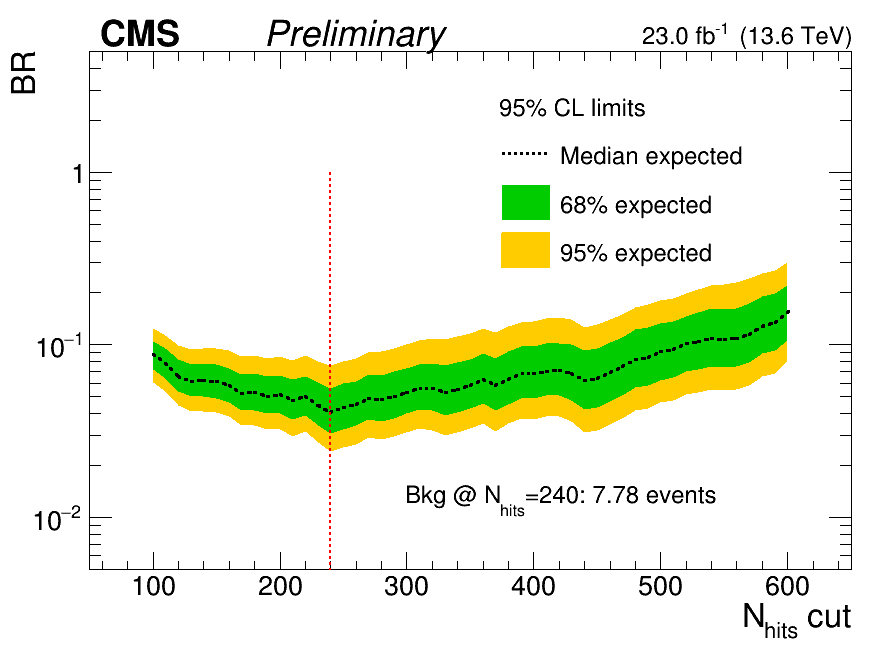

In [85]:
results = outDataCardsDir+'/n_cut_scan/'+'combine_results/'
exp = []
xval = []
obs = {}
mean_val = {}
sigma_2_up = {}
sigma_1_up = {}
sigma_1_down = {}
sigma_2_down = {}
for n_cut_scan in n_cut_scan_list:
    if n_cut_scan<=N_MIN:continue
    card_name = modelName+"_"+str(int(n_cut_scan))
    
    if not os.path.isfile(results+card_name+".txt"):
        continue
    card = open( results+card_name+".txt", 'r')
    val = card.read().splitlines()
    if len(val) == 0:
        continue
    if len(val) != 6 and not blind:
        continue
    print(val)
    
    if blind:
        sigma_2_down[n_cut_scan] = float(val[0])
        sigma_1_down[n_cut_scan] = float(val[1])
        mean_val[n_cut_scan]     = float(val[2])
        sigma_1_up[n_cut_scan]   = float(val[3])
        sigma_2_up[n_cut_scan]   = float(val[4])
    else:
        obs[n_cut_scan]          = float(val[0])
        sigma_2_down[n_cut_scan] = float(val[1])
        sigma_1_down[n_cut_scan] = float(val[2])
        mean_val[n_cut_scan]     = float(val[3])
        sigma_1_up[n_cut_scan]   = float(val[4])
        sigma_2_up[n_cut_scan]   = float(val[5])
        
Obs0s = rt.TGraph()
Exp0s = rt.TGraph()
Exp1s = rt.TGraphAsymmErrors()
Exp2s = rt.TGraphAsymmErrors()

n=0
for n_cut_scan in n_cut_scan_list:                                                                                                    
    if n_cut_scan not in mean_val.keys():
        continue
    if not blind:
        Obs0s.SetPoint(n, n_cut_scan, obs[n_cut_scan])
    Exp0s.SetPoint(n, n_cut_scan, mean_val[n_cut_scan])
    Exp1s.SetPoint(n, n_cut_scan, mean_val[n_cut_scan])
    Exp1s.SetPointError(n, 0., 0., mean_val[n_cut_scan]-sigma_1_down[n_cut_scan], sigma_1_up[n_cut_scan]-mean_val[n_cut_scan])
    Exp2s.SetPoint(n, n_cut_scan, mean_val[n_cut_scan])
    Exp2s.SetPointError(n, 0., 0., mean_val[n_cut_scan]-sigma_2_down[n_cut_scan], sigma_2_up[n_cut_scan]-mean_val[n_cut_scan])
    n+=1
    
Exp2s.SetLineWidth(2)
Exp2s.SetLineStyle(1)
Exp0s.SetLineStyle(2)
Exp0s.SetLineWidth(3)                                                                                                                            
Obs0s.SetLineStyle(1)
Obs0s.SetLineWidth(3)                                                                                                                          
Exp1s.SetFillColor(417)
Exp1s.SetLineColor(417)
Exp2s.SetFillColor(800)
Exp2s.SetLineColor(800)
Exp2s.GetXaxis().SetTitle("N_{hits} cut")
Exp2s.GetYaxis().SetTitle("BR")
Exp2s.GetXaxis().SetNoExponent(True)
Exp2s.GetXaxis().SetMoreLogLabels(True)
Exp2s.GetXaxis().SetTitleSize(0.048)
Exp2s.GetYaxis().SetTitleSize(0.048)                                                                                                                                           
Exp2s.GetXaxis().SetTitleOffset(0.9)
Exp2s.GetYaxis().SetTitleOffset(0.85)

leg = rt.TLegend(0.55, 0.575, 0.9-0.05, 0.875)
leg.SetBorderSize(0)
leg.SetHeader("95% CL limits")
leg.SetTextSize(0.04)
c1 = rt.TCanvas("c1", "Exclusion Limits", 900, 675)
c1.cd()
c1.GetPad(0).SetBottomMargin(0.12)
c1.GetPad(0).SetTopMargin(0.08)
c1.GetPad(0).SetRightMargin(0.05)
c1.GetPad(0).SetTicks(1, 1)
c1.GetPad(0).SetLogy()

leg.AddEntry(Exp0s,  "Median expected", "l")
leg.AddEntry(Exp1s, "68% expected", "f")
leg.AddEntry(Exp2s, "95% expected", "f")
if not blind:
    leg.AddEntry(Obs0s, "Observed", "l")
Exp2s.GetXaxis().SetTitleSize(0.055)
Exp2s.GetYaxis().SetTitleSize(0.055)
Exp2s.GetXaxis().SetLabelSize(0.045)                                                                                 
Exp2s.GetYaxis().SetLabelSize(0.045)

for mv in mean_val.keys():
    xval.append(mv)
    exp.append(mean_val[mv])

best_phi = rt.TLine(xval[ np.argmin(exp) ],0.005,xval[ np.argmin(exp) ],1)
best_phi.SetLineColor(2)
best_phi.SetLineStyle(2)
best_phi.SetLineWidth(2)


Exp2s.SetMinimum(0.005)
Exp2s.SetMaximum(5)
Exp2s.Draw("A3")
Exp1s.Draw("SAME, 3")
Exp0s.Draw("SAME, L")
if not blind:
    Obs0s.Draw("SAME, L")
best_phi.Draw("SAME, L")
leg.Draw()

latex = rt.TLatex()
latex.SetNDC()
latex.SetTextAlign(33)
latex.SetTextSize(0.04)
latex.SetTextFont(42)
latex.DrawLatex(0.8,0.25, ("Bkg @ N_{hits}=%s: %.2f events" % ( str(xval[ np.argmin(exp) ]),bkg_rate[ xval[ np.argmin(exp) ] ] [0])))

c1.Draw()
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.97,top_marg_lumi=0.965)

c1.Print("plots/V1p19_"+vers+"/ABCD_limits_scan_n_cut"+plot_string_plus+".pdf")
c1.Print("plots/V1p19_"+vers+"/ABCD_limits_scan_n_cut"+plot_string_plus+".png")
#Store graphs for future comparisons
newFile = rt.TFile("plots/V1p19_"+vers+"/ABCD_limits_scan_n_cut"+plot_string_plus+".root", "RECREATE")
newFile.cd()
Exp0s.Write("exp")
Exp1s.Write("1sigma")
Exp2s.Write("2sigma")
c1.Write()
newFile.Close()
print("Info: written "+"plots/V1p19_"+vers+"/ABCD_limits_scan_n_cut"+plot_string_plus+".root")

In [82]:
print(np.argmin(exp))
print(exp)
print(exp[ np.argmin(exp) ])
print(xval[ np.argmin(exp) ])
print(xval)
print(bkg_rate[ xval[ np.argmin(exp) ] ])

14
[0.0874, 0.0776, 0.0659, 0.0615, 0.062, 0.061, 0.0581, 0.0522, 0.0532, 0.0503, 0.0513, 0.0474, 0.0503, 0.0444, 0.0405, 0.0435, 0.0454, 0.0488, 0.0483, 0.0503, 0.0532, 0.0562, 0.0562, 0.0532, 0.0552, 0.0581, 0.063, 0.0581, 0.063, 0.0679, 0.0679, 0.0703, 0.0708, 0.0679, 0.062, 0.0635, 0.0688, 0.0747, 0.0825, 0.0845, 0.0913, 0.0942, 0.1016, 0.105, 0.1094, 0.1074, 0.1084, 0.1152, 0.1284, 0.1343, 0.1533]
0.0405
240
[100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600]
[7.782872189618174, 253.7216333815526, 652, 19.99999999999999]
